In [19]:

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import specific_humidity_from_dewpoint
from pint import UnitRegistry
ureg = UnitRegistry()
from windrose import WindroseAxes
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import rcParams
import re
import matplotlib.gridspec as gridspec


In [20]:



def extract_epoch_from_header_bulletproof(file_path):
    """
    Extract epoch/timestamp from .nas file header robustly.
    Returns: (skip_rows, epoch_datetime_str) or (None, None) if not found
    """
    if not os.path.exists(file_path):
        print(f"  ✗ File does not exist: {file_path}")
        return None, None
    
    skip_rows = 0
    epoch_str = None
    
    try:
        # METHOD 1: Try with proper BOM handling
        with open(file_path, 'rb') as f:
            # Check for BOM
            bom = f.read(3)
            if bom == b'\xef\xbb\xbf':  # UTF-8 BOM
                print("  Detected UTF-8 BOM")
            else:
                f.seek(0)  # Rewind if no BOM
        
            # Read as binary first to avoid encoding issues
            binary_content = f.read(5000)  # Read first 5KB
        
        # Decode with error handling
        try:
            content = binary_content.decode('utf-8')
        except UnicodeDecodeError:
            content = binary_content.decode('latin-1', errors='ignore')
        
        # Clean BOM if present
        content = content.replace('\ufeff', '').replace('\uFEFF', '')
        
        # Split into lines
        lines = content.split('\n')
        
    except Exception as e:
        print(f"  ✗ Error reading file: {e}")
        # Fallback to simple read
        try:
            with open(file_path, 'r', encoding='utf-8-sig', errors='replace') as f:
                lines = []
                for i in range(100):  # Read first 100 lines
                    line = f.readline()
                    if not line:
                        break
                    lines.append(line)
        except Exception as e2:
            print(f"  ✗ Fallback read also failed: {e2}")
            return None, None
    
    print(f"  Scanning {len(lines)} header lines...")
    
    # PATTERNS TO LOOK FOR (case-insensitive)
    patterns = [
        # startdate: YYYYMMDDHHMMSS pattern
        (r'startdate:\s*(\d{8}\d{0,6})', 'startdate'),
        (r'start\s*date:\s*(\d{8}\d{0,6})', 'start date'),
        (r'epoch:\s*(\d{8}\d{0,6})', 'epoch'),
        (r'date:\s*(\d{8}\d{0,6})', 'date'),
        (r'time:\s*(\d{8}\d{0,6})', 'time'),
        (r'datetime:\s*(\d{8}\d{0,6})', 'datetime'),
        
        # YYYY-MM-DD HH:MM:SS patterns
        (r'startdate:\s*(\d{4}-\d{2}-\d{2}\s*\d{2}:\d{2}:\d{2})', 'startdate with dashes'),
        (r'epoch:\s*(\d{4}-\d{2}-\d{2}\s*\d{2}:\d{2}:\d{2})', 'epoch with dashes'),
        
        # Unix timestamp
        (r'startdate:\s*(\d{10})', 'unix timestamp'),
        (r'epoch:\s*(\d{10})', 'unix epoch'),
        
        # ISO format
        (r'startdate:\s*(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', 'iso format'),
        
        # Generic date patterns anywhere in line
        (r'(\d{8}\d{6})\s', 'compact datetime (14 digits)'),
        (r'(\d{8}\d{4})\s', 'compact datetime (12 digits)'),
        (r'(\d{8})\s', 'compact date (8 digits)'),
        
        # Look for skiprows information
        (r'^\s*(\d+)\s*$', 'skiprow number'),
        (r'^(\d+)\s+', 'leading number'),
        (r'skip\s*rows?:\s*(\d+)', 'skip rows'),
        (r'header\s*lines?:\s*(\d+)', 'header lines'),
    ]
    
    # Also look for known header patterns
    header_keywords = [
        'header', 'metadata', 'comment', '#', 
        'startdate', 'epoch', 'date', 'time',
        'station', 'location', 'latitude', 'longitude',
        'created', 'generated', 'produced'
    ]
    
    skip_row_candidates = []
    epoch_candidates = []
    header_end_line = None
    
    for line_num, line in enumerate(lines):
        line = line.strip()
        if not line:  # Skip empty lines
            continue
        
        print(f"    Line {line_num}: {repr(line[:80])}")
        
        # Check if this looks like a skiprow number (just a number)
        if re.match(r'^\s*\d+\s*$', line):
            try:
                skip_value = int(line.strip())
                skip_row_candidates.append((line_num, skip_value))
                print(f"      Found skiprow candidate: {skip_value}")
            except:
                pass
        
        # Check for all patterns
        for pattern, pattern_name in patterns:
            match = re.search(pattern, line, re.IGNORECASE)
            if match:
                value = match.group(1)
                print(f"      Pattern '{pattern_name}' matched: {value}")
                
                if pattern_name in ['skiprow number', 'leading number', 'skip rows', 'header lines']:
                    try:
                        skip_row_candidates.append((line_num, int(value)))
                    except:
                        pass
                else:
                    # This might be an epoch/date value
                    epoch_candidates.append((line_num, value, pattern_name))
        
        # Check if line contains header keywords
        if any(keyword in line.lower() for keyword in header_keywords):
            print(f"      Contains header keyword")
            if header_end_line is None:
                header_end_line = line_num
        
        # Check if we've reached data (numbers separated by spaces/tabs)
        # This helps determine where header ends
        if re.match(r'^[\d\s\.\-+eE]+$', line.replace('\t', ' ')):
            print(f"      Looks like data (numbers only)")
            if header_end_line is None:
                header_end_line = line_num - 1
            break
    
    # DECISION LOGIC
    # Determine skip_rows
    if skip_row_candidates:
        # Use the first valid skiprow candidate (your original logic)
        skip_rows = skip_row_candidates[0][1] - 1 if skip_row_candidates[0][1] > 0 else 0
        print(f"  Selected skip_rows: {skip_rows} (from candidate {skip_row_candidates[0][1]})")
    elif header_end_line is not None:
        skip_rows = header_end_line + 1
        print(f"  Using header_end_line for skip_rows: {skip_rows}")
    else:
        # Default: skip first line if it's not numeric data
        if lines and not re.match(r'^[\d\s\.\-+]+$', lines[0].strip()):
            skip_rows = 1
            print(f"  Default skip_rows: {skip_rows}")
    
    # Determine epoch
    if epoch_candidates:
        # Try to parse each candidate
        for line_num, epoch_value, pattern_name in epoch_candidates:
            print(f"  Trying to parse epoch candidate: {epoch_value} ({pattern_name})")
            
            parsed_datetime = None
            
            try:
                # Handle different formats
                if re.match(r'^\d{14}$', epoch_value):  # YYYYMMDDHHMMSS
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d%H%M%S')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                elif re.match(r'^\d{12}$', epoch_value):  # YYYYMMDDHHMM
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d%H%M')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:00')
                
                elif re.match(r'^\d{8}$', epoch_value):  # YYYYMMDD
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d 00:00:00')
                
                elif re.match(r'^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}$', epoch_value):
                    parsed_datetime = datetime.strptime(epoch_value, '%Y-%m-%d %H:%M:%S')
                    epoch_str = epoch_value
                
                elif re.match(r'^\d{10}$', epoch_value):  # Unix timestamp
                    parsed_datetime = datetime.fromtimestamp(int(epoch_value))
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                elif re.match(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}$', epoch_value):
                    parsed_datetime = datetime.fromisoformat(epoch_value.replace('Z', '+00:00'))
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                if parsed_datetime:
                    print(f"  ✓ Successfully parsed epoch: {epoch_str}")
                    return skip_rows, epoch_str
                    
            except Exception as e:
                print(f"    ✗ Failed to parse {epoch_value}: {e}")
                continue
    
    # If no epoch found, check filename for date pattern
    filename = os.path.basename(file_path)
    print(f"  Checking filename for date pattern: {filename}")
    
    # Common patterns in filenames
    filename_patterns = [
        r'(\d{8})',  # YYYYMMDD
        r'(\d{12})',  # YYYYMMDDHHMM
        r'(\d{14})',  # YYYYMMDDHHMMSS
        r'(\d{4})(\d{2})(\d{2})',  # YYYY MM DD
    ]
    
    for pattern in filename_patterns:
        match = re.search(pattern, filename)
        if match:
            date_str = match.group(1)
            try:
                if len(date_str) == 14:
                    parsed = datetime.strptime(date_str, '%Y%m%d%H%M%S')
                    epoch_str = parsed.strftime('%Y-%m-%d %H:%M:%S')
                elif len(date_str) == 12:
                    parsed = datetime.strptime(date_str, '%Y%m%d%H%M')
                    epoch_str = parsed.strftime('%Y-%m-%d %H:%M:00')
                elif len(date_str) == 8:
                    parsed = datetime.strptime(date_str, '%Y%m%d')
                    epoch_str = parsed.strftime('%Y-%m-%d 00:00:00')
                
                if epoch_str:
                    print(f"  ✓ Extracted epoch from filename: {epoch_str}")
                    return skip_rows, epoch_str
            except:
                continue
    
    print(f"  ✗ No epoch found in file header or filename")
    return skip_rows, None  # Return skip_rows even if no epoch found

#

In [21]:
# READ nas file
# Function to extract epoch from the first few rows of the CSV file
# def extract_epoch_from_header(file):
#     # Read the first few lines to find the epoch (assuming it's in a comment or a header)
#     with open(file, 'r') as f:
#         skiprow = f.readline()
#         skiprow = skiprow.strip().split()[0]
#         for line in f:
#             if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
#                 # Extract the epoch date (this assumes the date is the second item in the line)
#                 epoch = line.strip().split()[1]
#                 return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
#     return None  # Return None if no epoch is found
# Your original code with the bulletproof function

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    #nskiprows,epoch = extract_epoch_from_header(file)
    nskiprows, epoch = extract_epoch_from_header_bulletproof(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['start_time'], unit='D') + pd.Timestamp(epoch)
    df = df[df.numflag_wind_speed != 0.999]
    #df.index = df["starttime_dt"]
    #data["starttime_dt"] = pd.to_datetime(data["starttime"],unit='D',origin=pd.Timestamp('2015-01-01 00:41:00'))
   
    # Return the adjusted DataFrame
    return df

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1015738/3164685674.py:26: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, skiprows=nskiprows,sep="\s+")  # Adjust skiprows based on where the data starts


In [22]:
# Set working directory (fixed the path - removed the ValueError)
working_dir = '../data_meteo/'

# Find all CSV files (using .nas extension as in your code)
meteo_files = glob.glob(working_dir + "*.nas")
print(f"Found {len(meteo_files)} files:")
for file in meteo_files:
    print(file)
# this function reads and adjust times for all CSV files
dfs = []
for file in meteo_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
meteoCG_df = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
#print(meteoCG_df)


Found 5 files:
../data_meteo/IT0014R.20240101000000.20250214101300.aws..met.1y.1mn...lev0.nas
../data_meteo/IT0014R.20150101000000.20160722000000.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20180101000000.20191111101200.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20160101000000.20170620000000.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20170101000000.20180404104400.aws..met.1y.1h...lev2.nas
  Scanning 72 header lines...
    Line 0: '68 1001'
      Pattern 'leading number' matched: 68
      Looks like data (numbers only)
  Selected skip_rows: 67 (from candidate 68)
  Checking filename for date pattern: IT0014R.20240101000000.20250214101300.aws..met.1y.1mn...lev0.nas
  ✓ Extracted epoch from filename: 2024-01-01 00:00:00
  Detected UTF-8 BOM
  Scanning 85 header lines...
    Line 0: '69 1001'
      Pattern 'leading number' matched: 69
      Looks like data (numbers only)
  Selected skip_rows: 68 (from candidate 69)
  Checking filename for date pattern: IT0014R.20150101000000.

In [23]:

meteoCG_df.set_index('starttime_dt', inplace=True)
# Check if there format hh:mm:ss is in the index
formatted_df_CG = meteoCG_df.copy()
formatted_df_CG.index = meteoCG_df.index.strftime('%Y-%m-%d %H:%M:%S')
print(formatted_df_CG.head())

                     start_time  end_time  wind_speed  numflag_wind_speed  \
starttime_dt                                                                
2015-01-01 00:00:00    0.000000  0.041667         2.1                 0.0   
2015-01-01 01:00:00    0.041667  0.083333         2.0                 0.0   
2015-01-01 01:59:59    0.083333  0.125000         2.3                 0.0   
2015-01-01 03:00:00    0.125000  0.166667         2.9                 0.0   
2015-01-01 04:00:00    0.166667  0.208333         3.2                 0.0   

                     wind_direction  numflag_wind_direction  temperature  \
starttime_dt                                                               
2015-01-01 00:00:00           356.6                     0.0        273.6   
2015-01-01 01:00:00           354.9                     0.0        274.2   
2015-01-01 01:59:59           359.9                     0.0        275.0   
2015-01-01 03:00:00           339.6                     0.0        276.1   
2015

In [24]:
''
formatted_df_CG.drop(columns=['start_time','end_time', 'relative_humidity', 'numflag_relative_humidity', 'pressure', 'numflag_pressure', 'global_radiation', 'numflag_global_radiation',
                               'solar_radiation','numflag_solar_radiation','precipitation_amount',  'numflag_precipitation_amount', 'temperature', 'numflag_temperature' ], inplace=True)
# Option 1: Using set_index()

formatted_df_CG.head()

wind_speed  numflag_wind_speed  wind_direction  \
starttime_dt                                                          
2015-01-01 00:00:00         2.1                 0.0           356.6   
2015-01-01 01:00:00         2.0                 0.0           354.9   
2015-01-01 01:59:59         2.3                 0.0           359.9   
2015-01-01 03:00:00         2.9                 0.0           339.6   
2015-01-01 04:00:00         3.2                 0.0           327.6   

                     numflag_wind_direction  
starttime_dt                                 
2015-01-01 00:00:00                     0.0  
2015-01-01 01:00:00                     0.0  
2015-01-01 01:59:59                     0.0  
2015-01-01 03:00:00                     0.0  
2015-01-01 04:00:00                     0.0

In [25]:


# Drop rows where 'values' equals 9.999999999
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]

count = len(formatted_df_CG)
# Count remaining lines
remaining_count = len(filt_df_CG)

print("Filtered DataFrame:")
#print(filt_df_CG)
print(f"\nNumber of lines before dropping: {count}")
print(f"\nNumber of lines after dropping: {remaining_count}")


Filtered DataFrame:

Number of lines before dropping: 200172

Number of lines after dropping: 200172


In [26]:
filt_df_CG.drop(columns=['numflag_wind_speed','numflag_wind_direction' ], inplace=True)

In [27]:
# Assuming df_filtered is your DataFrame with datetime index 'starttime_dt'

# Define date range
start_date = '2016-01-01'
end_date = '2019-12-31'

# Create subset based on date range using loc (inclusive of both dates)
meteo_CG_16_19 = filt_df_CG.loc[start_date:end_date]


# Print information about the subset
print(f"Date range: {start_date} to {end_date}")
print(f"Original DataFrame shape: {filt_df_CG.shape}")
print(f"Subset DataFrame shape: {meteo_CG_16_19.shape}")
print(f"Number of rows in subset: {len(meteo_CG_16_19)}")

# Show first few rows of the subset
print("\nFirst 5 rows of subset:")
print(meteo_CG_16_19.head())

Date range: 2016-01-01 to 2019-12-31
Original DataFrame shape: (200172, 2)
Subset DataFrame shape: (17123, 2)
Number of rows in subset: 17123

First 5 rows of subset:
                     wind_speed  wind_direction
starttime_dt                                   
2016-01-01 00:00:00         2.3            30.3
2016-01-01 01:00:00         1.0             7.9
2016-01-01 01:59:59         1.9            33.2
2016-01-01 03:00:00         2.4            28.0
2016-01-01 04:00:00         2.4            37.0


In [28]:

# Apply condition: keep rows where ws_2m > 0.5
meteo_CG_16_19_filt =meteo_CG_16_19[meteo_CG_16_19['wind_speed'] > 0.5]



# Count lines before and after
original_count = len(meteo_CG_16_19)
filtered_count = len(meteo_CG_16_19_filt)

print("Original DataFrame:")
print(original_count)
print(f"\nOriginal count: {original_count}")

print("\nFiltered DataFrame (ws_2m > 0.5):")
print(meteo_CG_16_19_filt)
print(f"\nFiltered count: {filtered_count}")

Original DataFrame:
17123

Original count: 17123

Filtered DataFrame (ws_2m > 0.5):
                     wind_speed  wind_direction
starttime_dt                                   
2016-01-01 00:00:00         2.3            30.3
2016-01-01 01:00:00         1.0             7.9
2016-01-01 01:59:59         1.9            33.2
2016-01-01 03:00:00         2.4            28.0
2016-01-01 04:00:00         2.4            37.0
...                         ...             ...
2018-12-30 19:59:59         5.0           313.2
2018-12-30 21:00:00         4.4           320.0
2018-12-30 22:00:00         2.6           335.6
2018-12-30 22:59:59         2.9           336.8
2018-12-31 00:00:00         3.3           329.1

[17078 rows x 2 columns]

Filtered count: 17078


In [ ]:
plt.scatter(meteo_CG_16_19_filt.index, meteo_CG_16_19_filt['wind_speed'], marker='x', s=0.06, color='blue', label='Temperature')

In [29]:
#Prepare the Data and Calculate Wind Sectors
# Add wind direction sectors (8-point compass)
def direction_to_sector(direction):
    """Convert wind direction in degrees to 8-point compass sectors"""
    sectors = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    sector_bounds = [22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5]
    
    for i, bound in enumerate(sector_bounds):
        if direction < bound:
            return sectors[i]
    return 'N'  # For directions between 337.5 and 360/0

In [30]:
# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")


print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# SOLUTION 1: If 'starttime_dt' is a column (most common case)
if 'starttime_dt' in meteo_CG_16_19_filt.columns:
    print("\n=== SOLUTION 1: Using 'starttime_dt' column ===")
    
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt['starttime_dt']):
        print("Converting 'starttime_dt' to datetime...")
        meteo_CG_16_19_filt['starttime_dt'] = pd.to_datetime(meteo_CG_16_19_filt['starttime_dt'])
    
    # Extract month from the COLUMN (using .dt.month)
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt['starttime_dt'].dt.month
    
    
    print("✓ Added month from column")
    print(meteo_CG_16_19_filt[['starttime_dt', 'wind_speed', 'wind_direction', 'month', 'month_name']].head())

# SOLUTION 2: If you want to use the index (and 'starttime_dt' is the index name)
elif meteo_CG_16_19_filt.index.name == 'starttime_dt':
    print("\n=== SOLUTION 2: Converting index to datetime ===")
    
    # Convert the index to datetime
    meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
    
    # Now you can use .month on the index
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
    
    
    print("✓ Added month from datetime index")
    print(meteo_CG_16_19_filt[['wind_speed', 'wind_direction', 'month']].head())

# SOLUTION 3: If the index contains datetime strings but isn't named
else:
    print("\n=== SOLUTION 3: Generic approach ===")
    
    # Try to convert index to datetime
    try:
        meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
        meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
        print("✓ Converted index to datetime and added month")
    except:
        print("✗ Could not convert index to datetime")
        
        # Last resort: check if any column looks like datetime
        for col in meteo_CG_16_19_filt.columns:
            if any(keyword in col.lower() for keyword in ['time', 'date', 'datetime']):
                print(f"Trying column: {col}")
                try:
                    meteo_CG_16_19_filt['month'] = pd.to_datetime(meteo_CG_16_19_filt[col]).dt.month
                    print(f"✓ Added month from column '{col}'")
                    break
                except:
                    continue

# Add season based on month
if 'month' in meteo_CG_16_19_filt.columns:
    print("\n=== ADDING SEASON ===")
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    
    meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt['month'].apply(get_season)
    
    print("✓ Added season column")
    print(f"\nSeason distribution:")
    print(meteo_CG_16_19_filt['season'].value_counts())
    
    print(f"\nMonth distribution:")
    

# Final check
print("\n=== FINAL DATAFRAME INFO ===")
print(f"Columns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nFirst few rows with new columns:")
cols_to_show = []
for col in ['starttime_dt', 'wind_speed', 'wind_direction', 'month',  'season']:
    if col in meteo_CG_16_19_filt.columns:
        cols_to_show.append(col)
print(meteo_CG_16_19_filt[cols_to_show].head())

=== DATAFRAME INFO ===
Shape: (17078, 2)

Columns: ['wind_speed', 'wind_direction']

Index type: <class 'pandas.core.indexes.base.Index'>
Index name: starttime_dt

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
dtype: object

=== SOLUTION 2: Converting index to datetime ===
✓ Added month from datetime index
                     wind_speed  wind_direction  month
starttime_dt                                          
2016-01-01 00:00:00         2.3            30.3      1
2016-01-01 01:00:00         1.0             7.9      1
2016-01-01 01:59:59         1.9            33.2      1
2016-01-01 03:00:00         2.4            28.0      1
2016-01-01 04:00:00         2.4            37.0      1

=== ADDING SEASON ===
✓ Added season column

Season distribution:
season
Winter    6279
Spring    5145
Autumn    2925
Summer    2729
Name: count, dtype: int64

Month distribution:

=== FINAL DATAFRAME INFO ===
Columns: ['wind_speed', 'wind_direction', 'month', 'season']

First few 

/tmp/ipykernel_1015738/1651369777.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
/tmp/ipykernel_1015738/1651369777.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt['month'].apply(get_season)


In [30]:
total_rows = len(meteo_CG_16_19_filt)
total_rows

17078

In [31]:
# Apply sector classification
meteo_CG_16_19_filt['Wind_Sector'] = meteo_CG_16_19_filt['wind_direction'].apply(direction_to_sector)

print("Wind Sector Distribution:")
print(meteo_CG_16_19_filt['Wind_Sector'].value_counts().sort_index())

Wind Sector Distribution:
Wind_Sector
E     1755
N     2568
NE    2562
NW    3691
S      969
SE    2465
SW     728
W     2340
Name: count, dtype: int64


/tmp/ipykernel_1015738/159629697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['Wind_Sector'] = meteo_CG_16_19_filt['wind_direction'].apply(direction_to_sector)


In [33]:


# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")
print(f"\nIndex values (first 5): {meteo_CG_16_19_filt.index[:5].tolist()}")

print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# Check for any datetime-like columns
datetime_keywords = ['time', 'date', 'datetime', 'dt', 'timestamp']
datetime_columns = []

for col in meteo_CG_16_19_filt.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in datetime_keywords):
        datetime_columns.append(col)
        print(f"Found datetime-like column: '{col}'")

# Also check if the index is datetime-like
if hasattr(meteo_CG_16_19_filt.index, 'dtype'):
    print(f"\nIndex dtype: {meteo_CG_16_19_filt.index.dtype}")
    if pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt.index):
        print("Index appears to be datetime!")

# Based on what we find, proceed accordingly
if datetime_columns:
    print(f"\n=== USING DATETIME COLUMNS FOUND ===")
    # Use the first datetime-like column
    datetime_col = datetime_columns[0]
    print(f"Using column '{datetime_col}' as datetime source")
    
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt[datetime_col]):
        print(f"Converting '{datetime_col}' to datetime...")
        meteo_CG_16_19_filt[datetime_col] = pd.to_datetime(meteo_CG_16_19_filt[datetime_col])
    
    # Extract month and year
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt[datetime_col].dt.month
    meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt[datetime_col].dt.year
    
    print(f"✓ Added month and year from column '{datetime_col}'")
    print(meteo_CG_16_19_filt[[datetime_col, 'wind_speed', 'wind_direction', 'month', 'year']].head())

elif pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt.index):
    print(f"\n=== USING DATETIME INDEX ===")
    
    # Extract month and year from index
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
    meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year
    
    print("✓ Added month and year from datetime index")
    print(meteo_CG_16_19_filt[['wind_speed', 'wind_direction', 'month', 'year']].head())

else:
    print(f"\n=== MANUAL DATETIME DETECTION ===")
    
    # Try to find any column that might contain dates
    date_found = False
    for col in meteo_CG_16_19_filt.columns:
        print(f"\nTesting column '{col}':")
        print(f"  Sample values: {meteo_CG_16_19_filt[col].head(3).tolist()}")
        
        try:
            # Try to convert to datetime
            test_dates = pd.to_datetime(meteo_CG_16_19_filt[col].head(10))
            print(f"  ✓ Can be converted to datetime")
            
            # Convert the whole column
            meteo_CG_16_19_filt['datetime'] = pd.to_datetime(meteo_CG_16_19_filt[col])
            meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt['datetime'].dt.month
            meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt['datetime'].dt.year
            
            print(f"✓ Added datetime, month, and year from column '{col}'")
            date_found = True
            break
            
        except Exception as e:
            print(f"  ✗ Cannot convert: {e}")
            continue
    
    if not date_found:
        print("\n✗ Could not find any datetime column. Please check your data.")
        print("Possible solutions:")
        print("1. Check if you have a column with dates/times")
        print("2. Make sure the column name is spelled correctly")
        print("3. Your data might already have 'month' and 'year' columns")

# Add season based on month with your winter definition
if 'month' in meteo_CG_16_19_filt.columns and 'year' in meteo_CG_16_19_filt.columns:
    print("\n=== ADDING SEASON (with your winter definition) ===")
    
    def get_season(row):
        """
        Winter i-year = January i-year + November and December (i-1)-year
        So:
        - Jan: part of Winter of current year
        - Nov, Dec: part of Winter of NEXT year
        """
        month = row['month']
        year = row['year']
        
        if month in [2, 3, 4]:
            return 'Spring'
        elif month in [5, 6, 7]:
            return 'Summer'
        elif month in [8, 9, 10]:
            return 'Autumn'
        elif month == 1:
            # January is part of Winter of the current year
            return 'Winter'
        elif month in [11, 12]:
            # November and December are part of Winter of NEXT year
            return 'Winter'
        else:
            return 'Unknown'
    
    # Apply the function to each row
    meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt.apply(get_season, axis=1)
    
    # Create a 'season_year' column to identify which winter each record belongs to
    def get_season_year(row):
        """
        Determine which year's season this record belongs to.
        For non-winter months: use current year
        For Jan: use current year (Winter 2017 includes Jan 2017)
        For Nov, Dec: use NEXT year (Winter 2017 includes Nov-Dec 2016)
        """
        month = row['month']
        year = row['year']
        
        if month in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
            # Spring, Summer, Autumn: use current year
            return year
        elif month == 1:
            # January: Winter of current year
            return year
        elif month in [11, 12]:
            # November, December: Winter of NEXT year
            return year + 1
        else:
            return year
    
    meteo_CG_16_19_filt['season_year'] = meteo_CG_16_19_filt.apply(get_season_year, axis=1)
    
    # Create a combined season identifier
    meteo_CG_16_19_filt['season_period'] = meteo_CG_16_19_filt['season'] + ' ' + meteo_CG_16_19_filt['season_year'].astype(str)
    
    print("✓ Added season, season_year, and season_period columns")
    
    # Show season distribution
    print(f"\nSeason distribution (2016-2019):")
    print(meteo_CG_16_19_filt['season'].value_counts().sort_index())
    
    print(f"\nSeason-year distribution:")
    season_year_counts = meteo_CG_16_19_filt['season_period'].value_counts().sort_index()
    print(season_year_counts)
    
    # Show winter composition
    print(f"\n=== WINTER COMPOSITION (based on your definition) ===")
    if 'Winter' in meteo_CG_16_19_filt['season'].values:
        winter_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == 'Winter']
        print("Winter records by season_year:")
        for season_year in sorted(winter_data['season_year'].unique()):
            winter_year_data = winter_data[winter_data['season_year'] == season_year]
            months = winter_year_data['month'].unique()
            years = winter_year_data['year'].unique()
            print(f"\nWinter {season_year}: {len(winter_year_data)} records")
            print(f"  Months included: {sorted(months)}")
            print(f"  Source years: {sorted(years)}")
            if 1 in months and 11 in months:
                print(f"  Composition: Jan {season_year} + Nov-Dec {season_year-1}")
    else:
        print("No winter data found in the dataset.")

# Final check
print("\n=== FINAL DATAFRAME INFO ===")
print(f"Columns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nFirst few rows with new columns:")

# Create list of columns to show
cols_to_show = ['wind_speed', 'wind_direction', 'month', 'year', 'season', 'season_year', 'season_period']

# Add any datetime column we found
if datetime_columns:
    cols_to_show.insert(0, datetime_columns[0])
elif 'datetime' in meteo_CG_16_19_filt.columns:
    cols_to_show.insert(0, 'datetime')

print(meteo_CG_16_19_filt[cols_to_show].head(10))

# If you still have issues, try this simplified approach:
print("\n=== ALTERNATIVE: SIMPLIFIED APPROACH ===")
print("If the above doesn't work, let's check if 'month' already exists:")

if 'month' in meteo_CG_16_19_filt.columns:
    print("'month' column already exists!")
    # Check if we need to extract year from somewhere
    if 'year' not in meteo_CG_16_19_filt.columns:
        print("'year' column not found. Let's check the index for year info...")
        # If index has dates, extract year from index
        try:
            # Try to parse index as dates
            temp_index = pd.to_datetime(meteo_CG_16_19_filt.index, errors='coerce')
            if temp_index.notna().any():
                meteo_CG_16_19_filt['year'] = temp_index.year
                print("✓ Added year from index")
        except:
            print("Could not extract year from index")
            
            # Last resort: check if there's date info in column names
            for col in meteo_CG_16_19_filt.columns:
                if '2016' in str(col) or '2017' in str(col) or '2018' in str(col) or '2019' in str(col):
                    print(f"Found year reference in column: {col}")

=== DATAFRAME INFO ===
Shape: (17078, 8)

Columns: ['wind_speed', 'wind_direction', 'month', 'season', 'Wind_Sector', 'year', 'season_year', 'season_period']

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: starttime_dt

Index values (first 5): [Timestamp('2016-01-01 00:00:00'), Timestamp('2016-01-01 01:00:00'), Timestamp('2016-01-01 01:59:59'), Timestamp('2016-01-01 03:00:00'), Timestamp('2016-01-01 04:00:00')]

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
month               int32
season             object
Wind_Sector        object
year                int32
season_year         int64
season_period      object
dtype: object

Index dtype: datetime64[ns]
Index appears to be datetime!

=== USING DATETIME INDEX ===
✓ Added month and year from datetime index
                     wind_speed  wind_direction  month  year
starttime_dt                                                
2016-01-01 00:00:00         2.3            30.3      1  201

/tmp/ipykernel_1015738/3009625784.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
/tmp/ipykernel_1015738/3009625784.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year
/tmp/ipykernel_1015738/3009625784.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

✓ Added season, season_year, and season_period columns

Season distribution (2016-2019):
season
Autumn    2855
Spring    5643
Summer    3460
Winter    5120
Name: count, dtype: int64

Season-year distribution:
season_period
Autumn 2016     964
Autumn 2018    1891
Spring 2016    2099
Spring 2017    1550
Spring 2018    1994
Summer 2016    1253
Summer 2017       3
Summer 2018    2204
Winter 2016     743
Winter 2017    1486
Winter 2018    1555
Winter 2019    1336
Name: count, dtype: int64

=== WINTER COMPOSITION (based on your definition) ===
Winter records by season_year:

Winter 2016: 743 records
  Months included: [np.int32(1)]
  Source years: [np.int32(2016)]

Winter 2017: 1486 records
  Months included: [np.int32(1), np.int32(12)]
  Source years: [np.int32(2016), np.int32(2017)]

Winter 2018: 1555 records
  Months included: [np.int32(1), np.int32(11), np.int32(12)]
  Source years: [np.int32(2017), np.int32(2018)]
  Composition: Jan 2018 + Nov-Dec 2017

Winter 2019: 1336 records
  Month

/tmp/ipykernel_1015738/3009625784.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season_year'] = meteo_CG_16_19_filt.apply(get_season_year, axis=1)
/tmp/ipykernel_1015738/3009625784.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season_period'] = meteo_CG_16_19_filt['season'] + ' ' + meteo_CG_16_19_filt['season_year'].astype(str)


In [34]:


# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")
print(f"\nIndex values (first 5):")
print(meteo_CG_16_19_filt.index[:5])

print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# Check if index is already datetime
print(f"\n=== CHECKING INDEX DATETIME STATUS ===")
print(f"Index dtype: {meteo_CG_16_19_filt.index.dtype}")

# Check if index needs to be converted to datetime
if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt.index):
    print("\nIndex is not datetime, converting...")
    try:
        meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
        print("✓ Successfully converted index to datetime")
    except Exception as e:
        print(f"✗ Could not convert index to datetime: {e}")
        # Try alternative approach
        print("\nTrying alternative approach...")
        
        # Check if there's a datetime column in the dataframe
        datetime_columns = []
        for col in meteo_CG_16_19_filt.columns:
            if any(keyword in col.lower() for keyword in ['time', 'date', 'datetime', 'dt', 'timestamp']):
                datetime_columns.append(col)
        
        if datetime_columns:
            print(f"Found datetime-like columns: {datetime_columns}")
            # Use the first datetime column found
            datetime_col = datetime_columns[0]
            print(f"Using column '{datetime_col}' as datetime source")
            
            # Convert to datetime if needed
            if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt[datetime_col]):
                print(f"Converting '{datetime_col}' to datetime...")
                meteo_CG_16_19_filt[datetime_col] = pd.to_datetime(meteo_CG_16_19_filt[datetime_col])
            
            # Extract month and year
            meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt[datetime_col].dt.month
            meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt[datetime_col].dt.year
            
            print(f"✓ Added month and year from column '{datetime_col}'")
        else:
            print("No datetime columns found. Cannot proceed without datetime information.")
            exit()
else:
    print("✓ Index is already datetime")
    
    # Now you can use .month and .year on the index
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
    meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year
    
    print("✓ Added month and year from datetime index")
    print(meteo_CG_16_19_filt[['wind_speed', 'wind_direction', 'month', 'year']].head())

# Add season based on month with your winter definition
if 'month' in meteo_CG_16_19_filt.columns and 'year' in meteo_CG_16_19_filt.columns:
    print("\n=== ADDING SEASON (with your winter definition) ===")
    
    def get_season(row):
        """
        Winter i-year = January i-year + November and December (i-1)-year
        So:
        - Jan: part of Winter of current year
        - Nov, Dec: part of Winter of NEXT year
        """
        month = row['month']
        year = row['year']
        
        if month in [2, 3, 4]:
            return 'Spring'
        elif month in [5, 6, 7]:
            return 'Summer'
        elif month in [8, 9, 10]:
            return 'Autumn'
        elif month == 1:
            # January is part of Winter of the current year
            # Winter 2017 includes Jan 2017 (with Nov-Dec 2016)
            return 'Winter'
        elif month in [11, 12]:
            # November and December are part of Winter of NEXT year
            # Winter 2017 includes Nov-Dec 2016
            return 'Winter'
        else:
            return 'Unknown'
    
    # Apply the function to each row
    meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt.apply(get_season, axis=1)
    
    # Now we need to create a 'season_year' column to identify which winter each record belongs to
    print("\n=== ADDING SEASON_YEAR FOR WINTER IDENTIFICATION ===")
    
    def get_season_year(row):
        """
        Determine which year's season this record belongs to.
        For non-winter months: use current year
        For Jan: use current year (Winter 2017 includes Jan 2017)
        For Nov, Dec: use NEXT year (Winter 2017 includes Nov-Dec 2016)
        """
        month = row['month']
        year = row['year']
        
        if month in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
            # Spring, Summer, Autumn: use current year
            return year
        elif month == 1:
            # January: Winter of current year
            return year
        elif month in [11, 12]:
            # November, December: Winter of NEXT year
            return year + 1
        else:
            return year
    
    meteo_CG_16_19_filt['season_year'] = meteo_CG_16_19_filt.apply(get_season_year, axis=1)
    
    # Create a combined season identifier
    meteo_CG_16_19_filt['season_period'] = meteo_CG_16_19_filt['season'] + ' ' + meteo_CG_16_19_filt['season_year'].astype(str)
    
    print("✓ Added season, season_year, and season_period columns")
    
    print(f"\nSeason distribution (2016-2019):")
    print(meteo_CG_16_19_filt['season'].value_counts().sort_index())
    
    print(f"\nSeason-year distribution:")
    season_year_counts = meteo_CG_16_19_filt['season_period'].value_counts().sort_index()
    print(season_year_counts)
    
    # Show winter composition
    print(f"\n=== WINTER COMPOSITION (based on your definition) ===")
    winter_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == 'Winter']
    if len(winter_data) > 0:
        print("Winter records by season_year:")
        for season_year in sorted(winter_data['season_year'].unique()):
            winter_year_data = winter_data[winter_data['season_year'] == season_year]
            months = winter_year_data['month'].unique()
            years = winter_year_data['year'].unique()
            print(f"\nWinter {season_year}: {len(winter_year_data)} records")
            print(f"  - Months included: {sorted(months)}")
            print(f"  - Source years: {sorted(years)}")
            if 1 in months and 11 in months:
                print(f"  - Composition: Jan {season_year} + Nov-Dec {season_year-1}")
    else:
        print("No winter data found.")

# Final check
print("\n=== FINAL DATAFRAME INFO ===")
print(f"Columns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nFirst few rows with new columns:")

# Show available columns
cols_to_show = ['wind_speed', 'wind_direction', 'month', 'year', 'season', 'season_year', 'season_period']

# Check if we have the index column to show
if hasattr(meteo_CG_16_19_filt.index, 'name') and meteo_CG_16_19_filt.index.name:
    print(f"\nIndex name: {meteo_CG_16_19_filt.index.name}")
    # Create a temporary dataframe with index as column for display
    display_df = meteo_CG_16_19_filt[cols_to_show].copy()
    display_df.insert(0, 'index', meteo_CG_16_19_filt.index)
    print(display_df.head(10))
else:
    print(meteo_CG_16_19_filt[cols_to_show].head(10))

# Example: Show some winter records to verify
print("\n=== EXAMPLE WINTER RECORDS ===")
if 'season' in meteo_CG_16_19_filt.columns:
    winter_sample = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == 'Winter'].head(5)
    
    # Create display with index
    if hasattr(winter_sample.index, 'name') and winter_sample.index.name:
        winter_display = winter_sample[['month', 'year', 'season', 'season_year', 'season_period']].copy()
        winter_display.insert(0, 'index', winter_sample.index)
        print(winter_display)
    else:
        print(winter_sample[['month', 'year', 'season', 'season_year', 'season_period']])

print("\n=== DATA SUMMARY ===")
print(f"Total records: {len(meteo_CG_16_19_filt)}")
print(f"Date range: {meteo_CG_16_19_filt.index.min()} to {meteo_CG_16_19_filt.index.max()}")
print(f"Years covered: {sorted(meteo_CG_16_19_filt['year'].unique())}")

=== DATAFRAME INFO ===
Shape: (17078, 8)

Columns: ['wind_speed', 'wind_direction', 'month', 'season', 'Wind_Sector', 'year', 'season_year', 'season_period']

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: starttime_dt

Index values (first 5):
DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 01:59:59', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00'],
              dtype='datetime64[ns]', name='starttime_dt', freq=None)

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
month               int32
season             object
Wind_Sector        object
year                int32
season_year         int64
season_period      object
dtype: object

=== CHECKING INDEX DATETIME STATUS ===
Index dtype: datetime64[ns]
✓ Index is already datetime
✓ Added month and year from datetime index
                     wind_speed  wind_direction  month  year
starttime_dt                                         

/tmp/ipykernel_1015738/2039119609.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
/tmp/ipykernel_1015738/2039119609.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year
/tmp/ipykernel_1015738/2039119609.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

✓ Added season, season_year, and season_period columns

Season distribution (2016-2019):
season
Autumn    2855
Spring    5643
Summer    3460
Winter    5120
Name: count, dtype: int64

Season-year distribution:
season_period
Autumn 2016     964
Autumn 2018    1891
Spring 2016    2099
Spring 2017    1550
Spring 2018    1994
Summer 2016    1253
Summer 2017       3
Summer 2018    2204
Winter 2016     743
Winter 2017    1486
Winter 2018    1555
Winter 2019    1336
Name: count, dtype: int64

=== WINTER COMPOSITION (based on your definition) ===
Winter records by season_year:

Winter 2016: 743 records
  - Months included: [np.int32(1)]
  - Source years: [np.int32(2016)]

Winter 2017: 1486 records
  - Months included: [np.int32(1), np.int32(12)]
  - Source years: [np.int32(2016), np.int32(2017)]

Winter 2018: 1555 records
  - Months included: [np.int32(1), np.int32(11), np.int32(12)]
  - Source years: [np.int32(2017), np.int32(2018)]
  - Composition: Jan 2018 + Nov-Dec 2017

Winter 2019: 1336 r

/tmp/ipykernel_1015738/2039119609.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season_year'] = meteo_CG_16_19_filt.apply(get_season_year, axis=1)
/tmp/ipykernel_1015738/2039119609.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season_period'] = meteo_CG_16_19_filt['season'] + ' ' + meteo_CG_16_19_filt['season_year'].astype(str)


=== DATAFRAME INFO ===
Shape: (17078, 8)

Columns: ['wind_speed', 'wind_direction', 'month', 'season', 'Wind_Sector', 'year', 'season_year', 'season_period']

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: starttime_dt

Index values (first 5):
DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 01:59:59', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00'],
              dtype='datetime64[ns]', name='starttime_dt', freq=None)

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
month               int32
season             object
Wind_Sector        object
year                int32
season_year         int64
season_period      object
dtype: object

=== CHECKING INDEX DATETIME STATUS ===
Index dtype: datetime64[ns]
✓ Index is already datetime
✓ Added month and year from datetime index
                     wind_speed  wind_direction  month  year
starttime_dt                                         

/tmp/ipykernel_1015738/761361506.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
/tmp/ipykernel_1015738/761361506.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year
/tmp/ipykernel_1015738/761361506.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

✓ Added season, season_year, and season_period columns

=== Creating wind rose figure for Winter ===
✓ Figure saved as 'wind_rose_CG_winter_2016_2019.png'


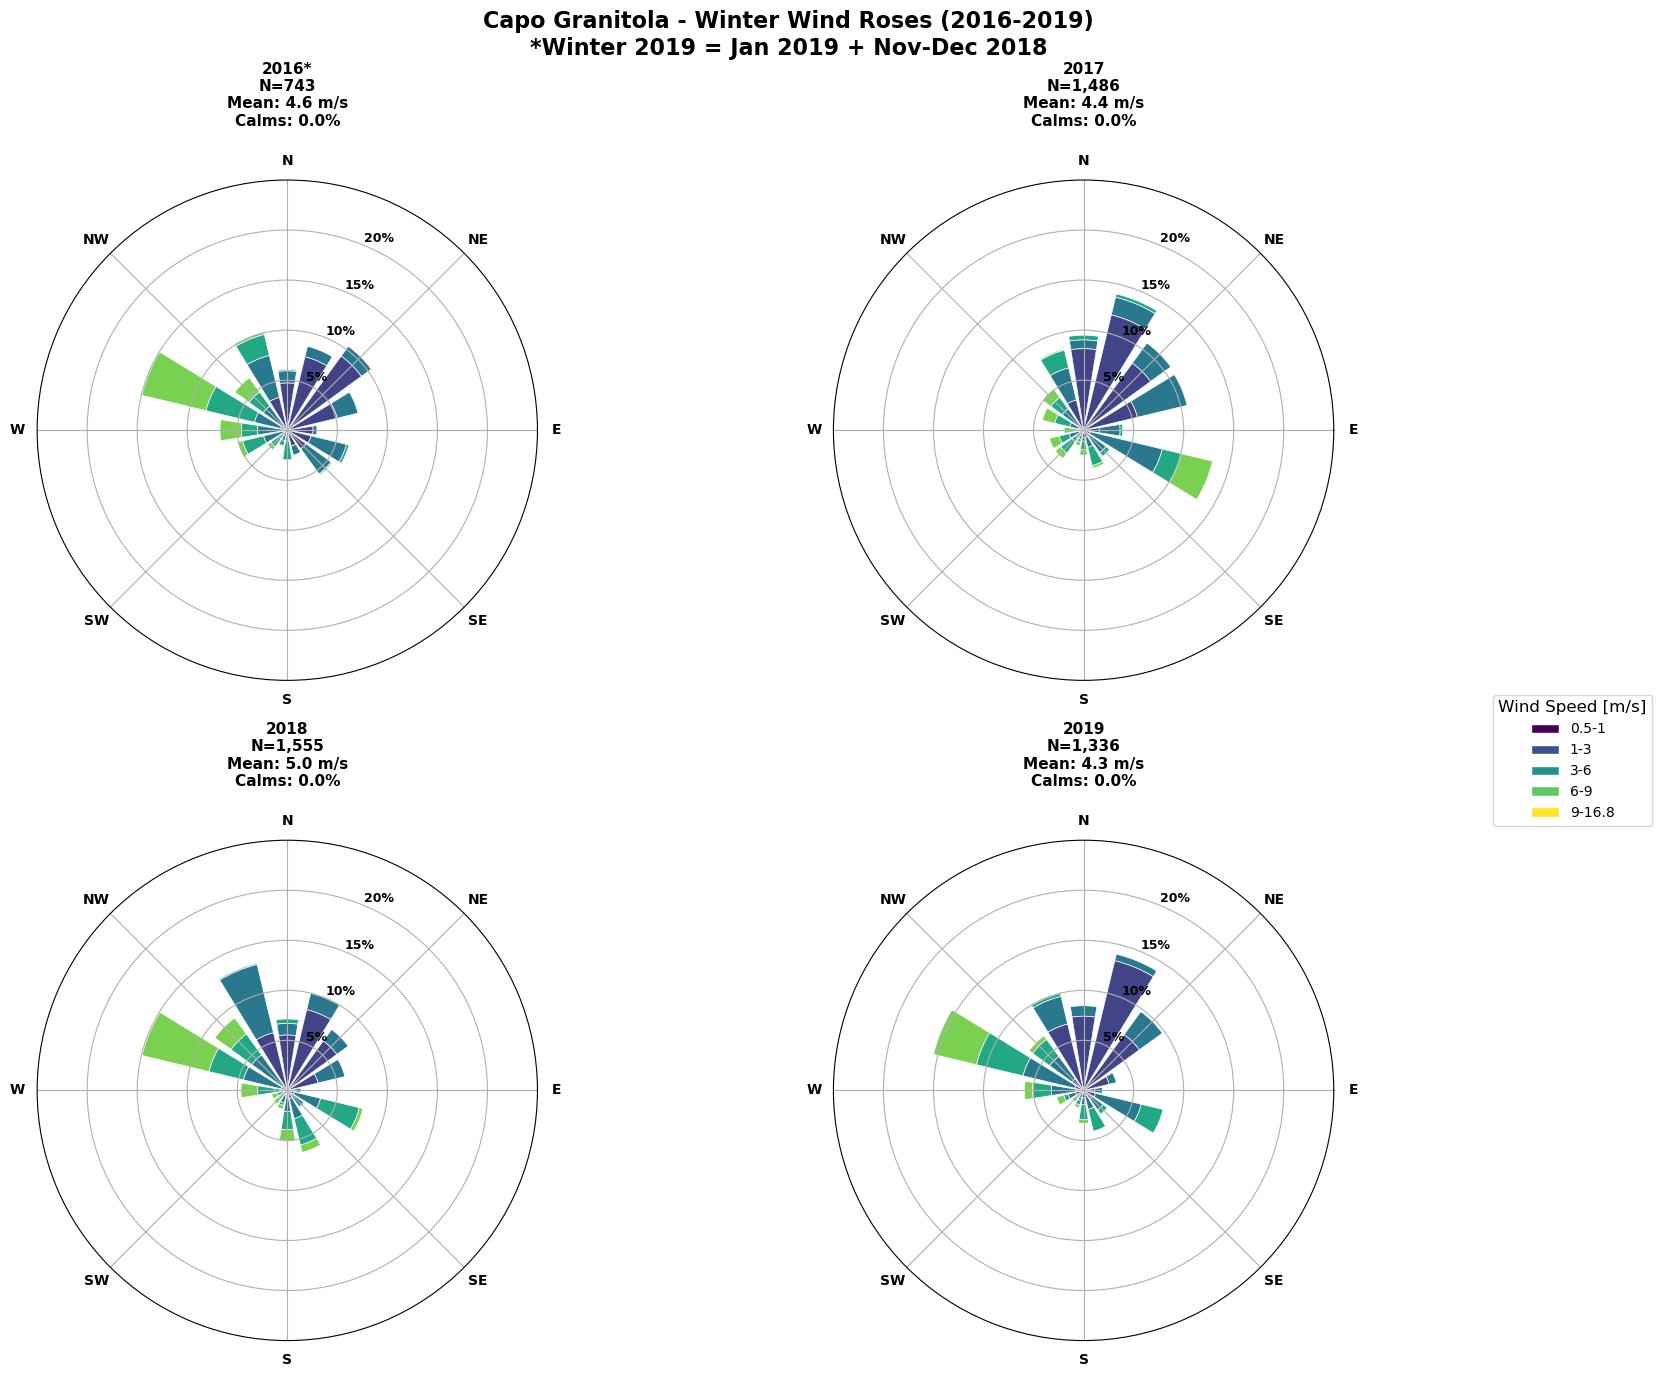


=== Creating wind rose figure for Spring ===
✓ Figure saved as 'wind_rose_CG_spring_2016_2019.png'


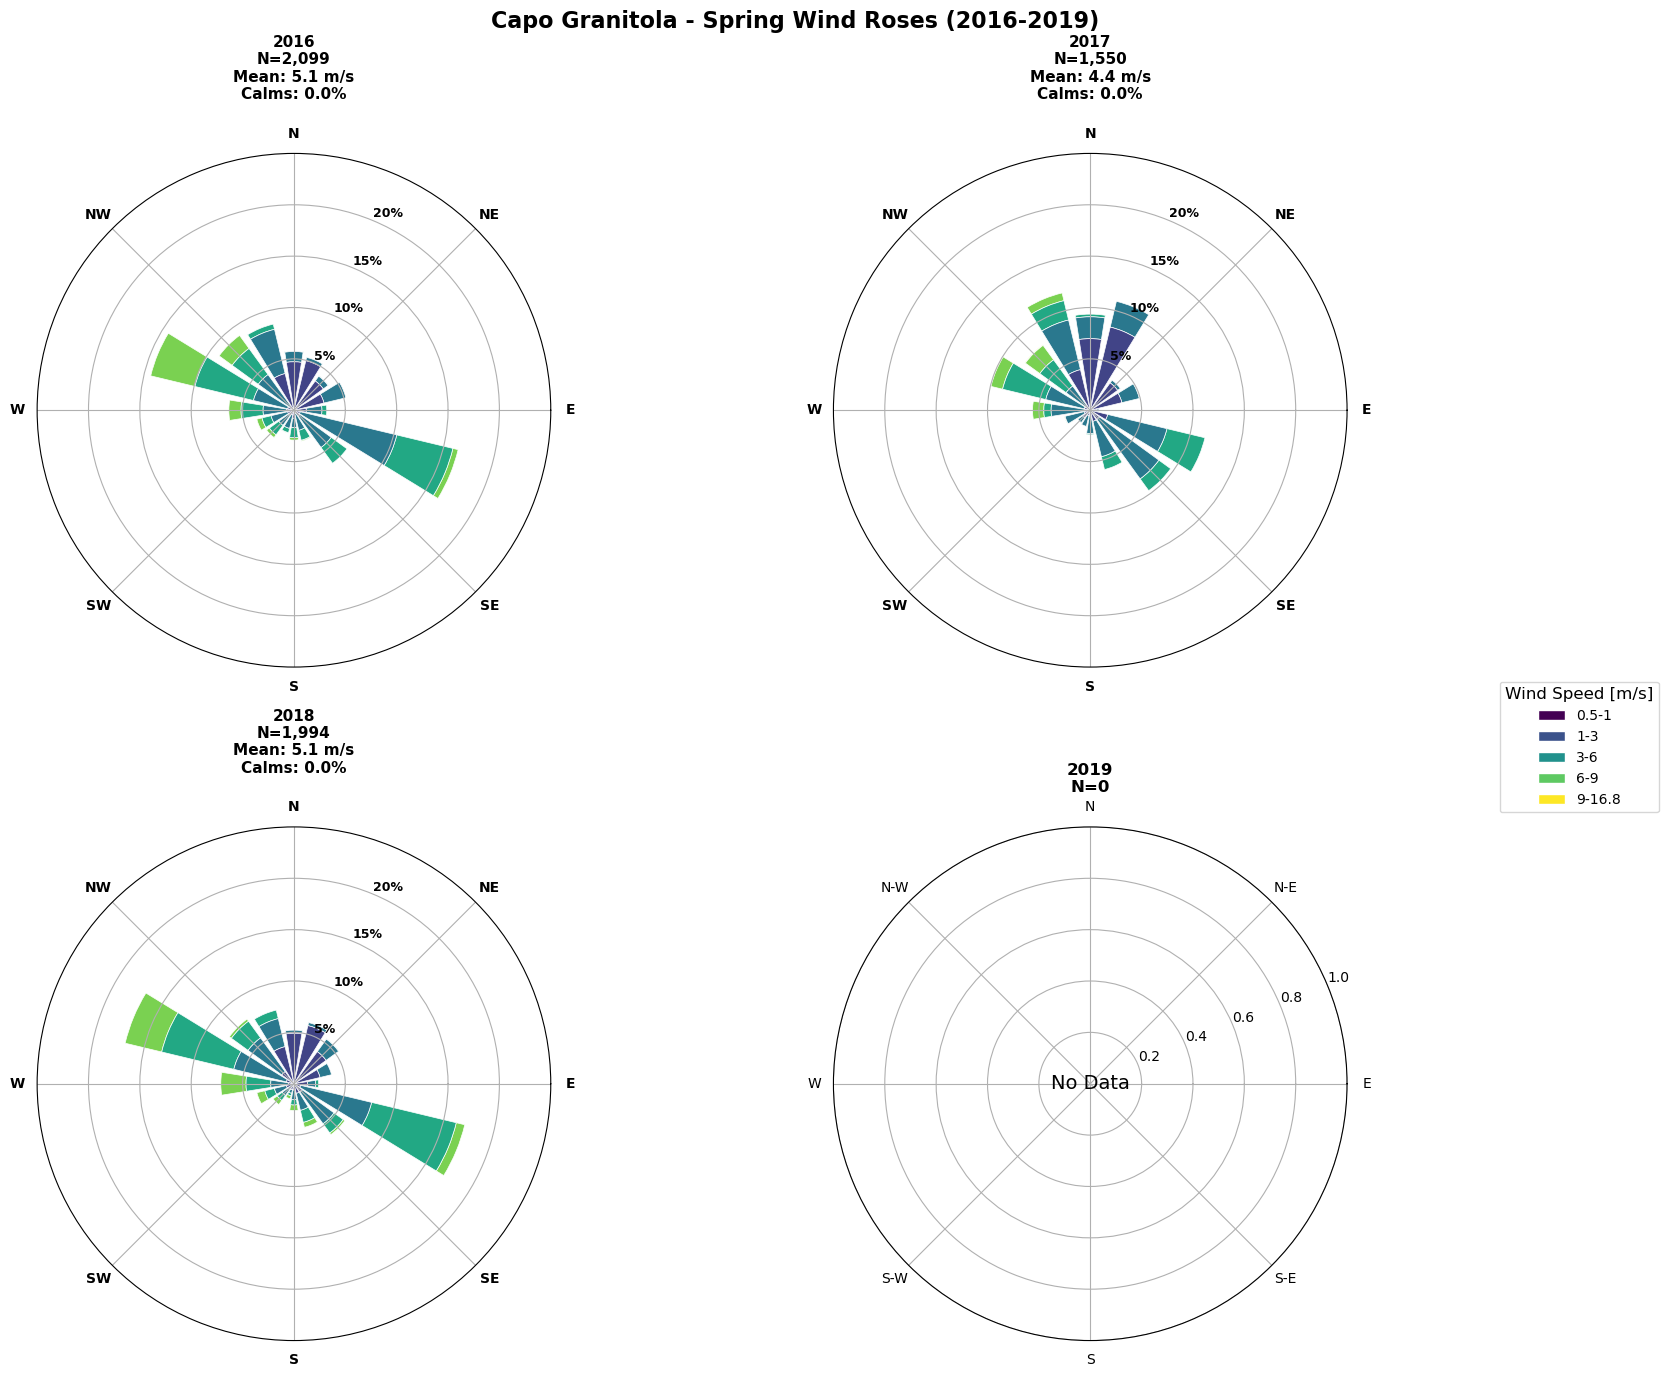


=== Creating wind rose figure for Summer ===
✓ Figure saved as 'wind_rose_CG_summer_2016_2019.png'


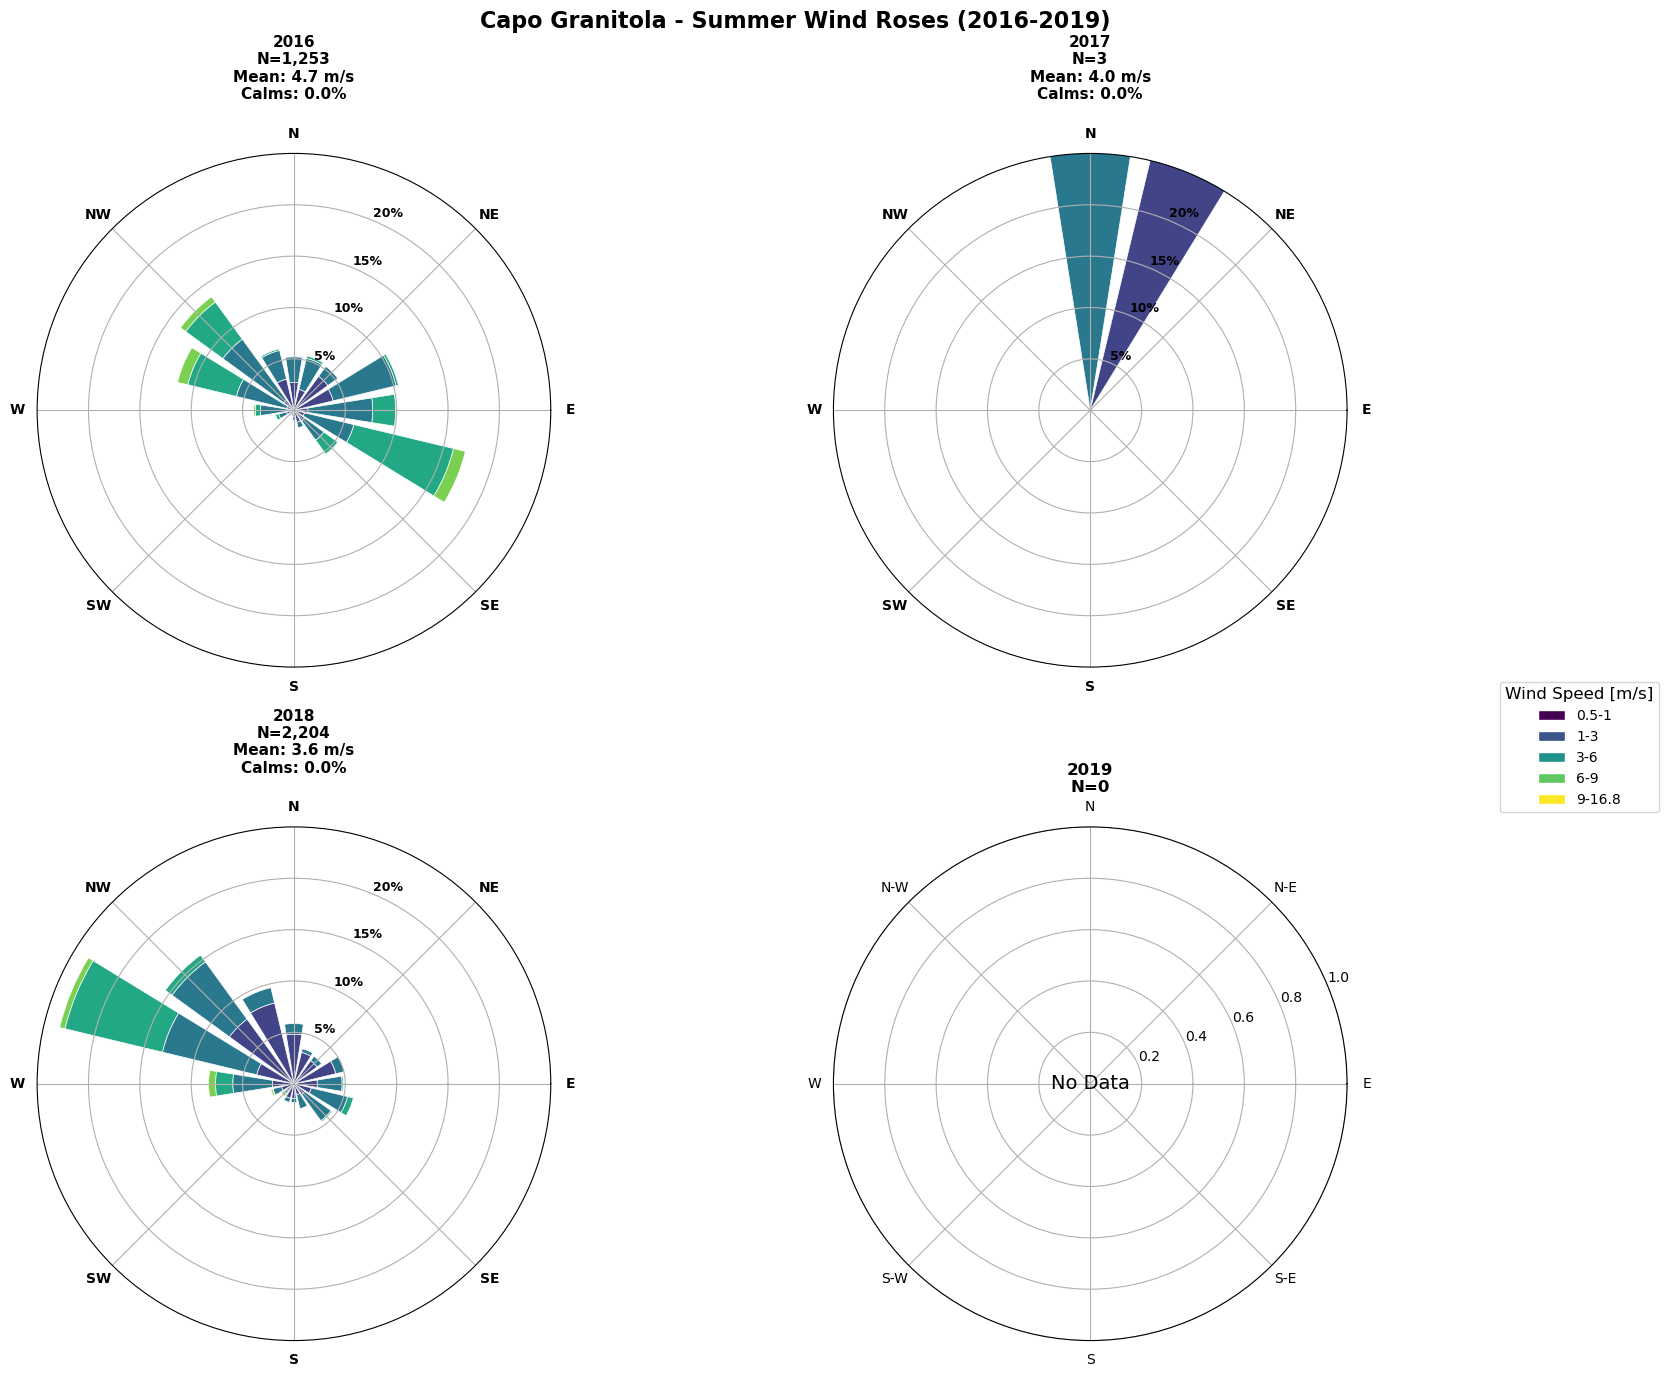


=== Creating wind rose figure for Autumn ===
✓ Figure saved as 'wind_rose_CG_autumn_2016_2019.png'


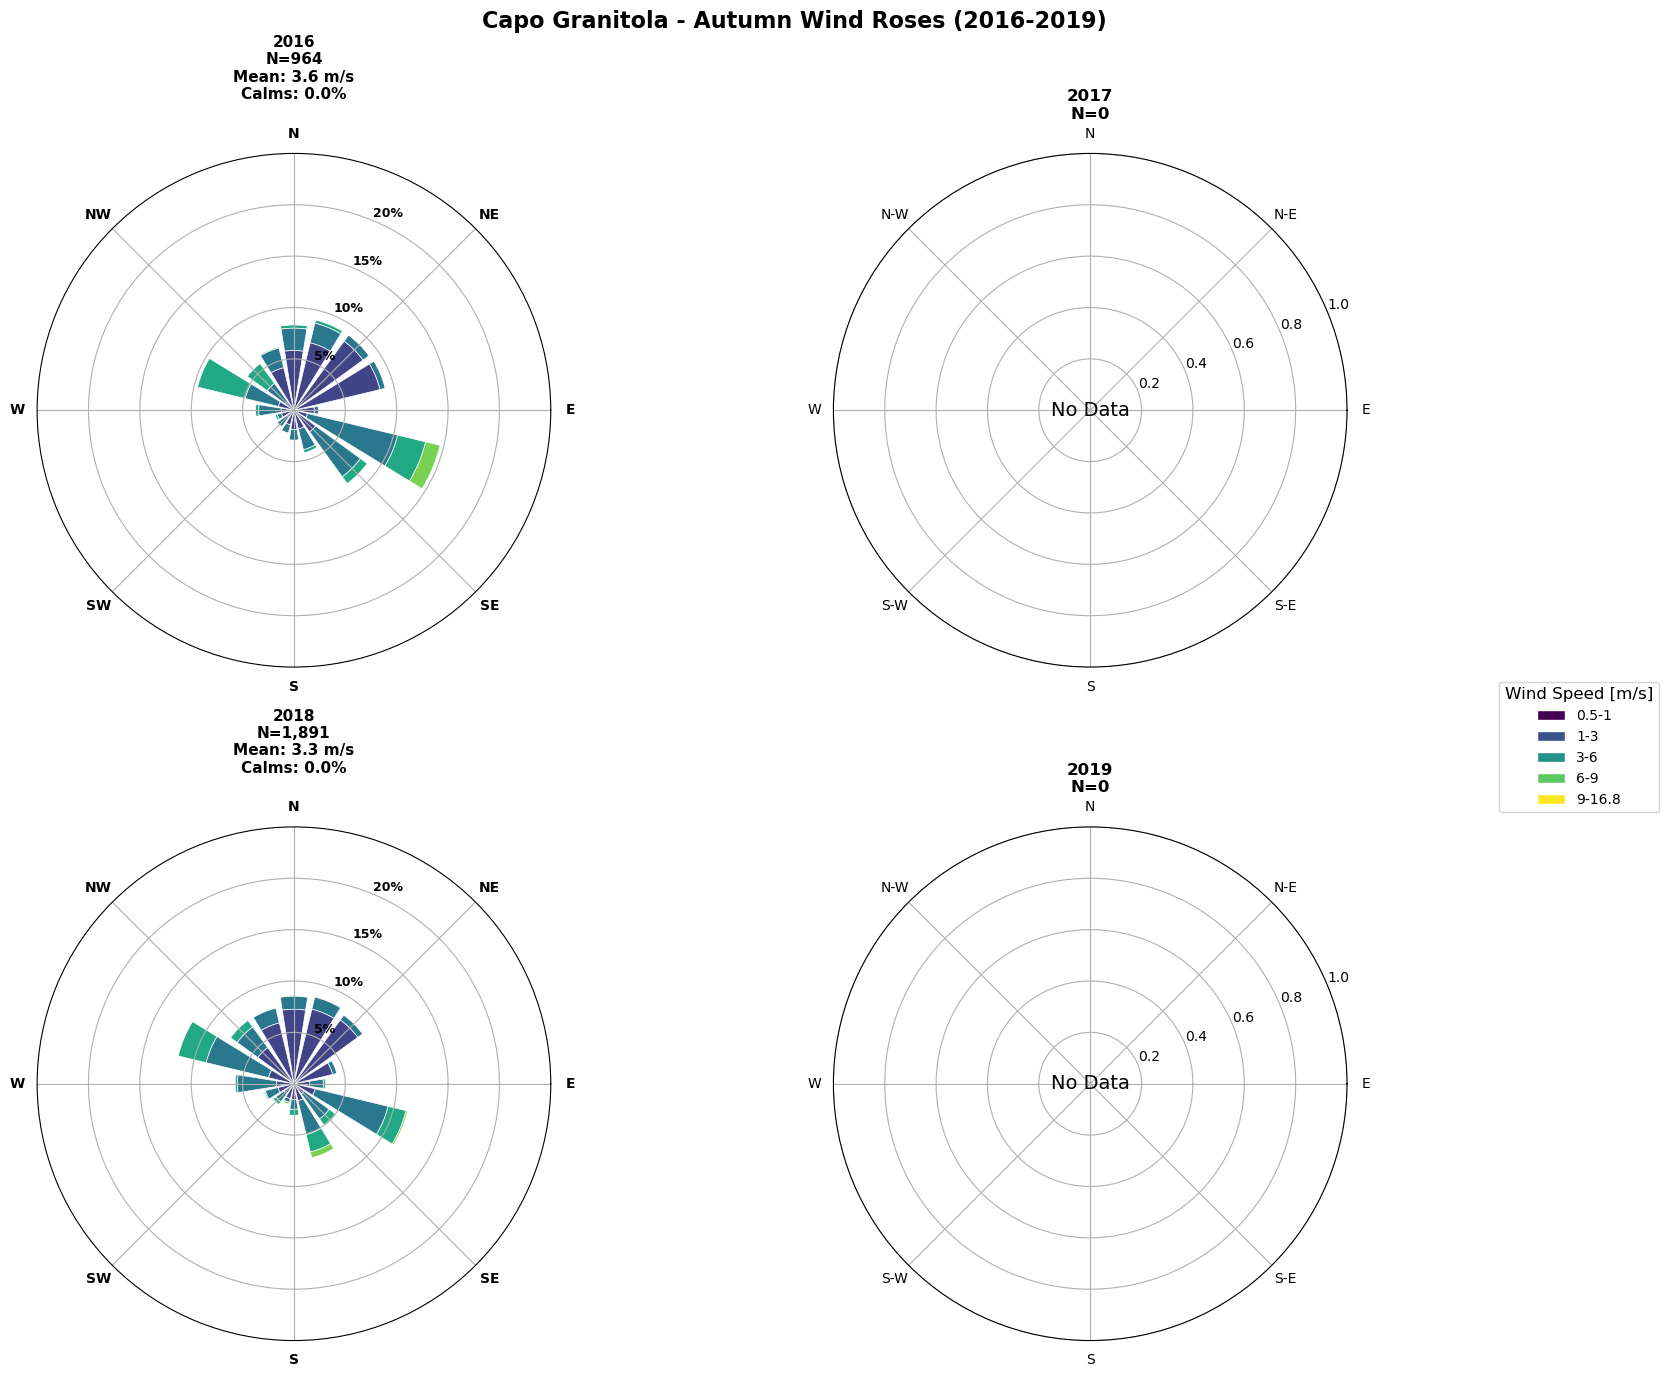


=== Creating summary figure with all seasons and years ===
✓ Summary figure saved as 'wind_rose_CG_all_seasons_years_summary.png'



=== DATA SUMMARY BY SEASON AND YEAR ===

SEASONAL WIND DATA SUMMARY (2016-2019)
 Season-Year    N Mean Speed (m/s) Max Speed (m/s) Calms (%)
 Winter 2016  743             4.64           14.30       0.0
Winter 2017* 1486             4.38           15.40       0.0
Winter 2018* 1555             5.03           15.90       0.0
Winter 2019* 1336             4.33           15.60       0.0
 Spring 2016 2099             5.06           15.50       0.0
 Spring 2017 1550             4.44           16.80       0.0
 Spring 2018 1994             5.06           13.60       0.0
 Summer 2016 1253             4.74           11.70       0.0
 Summer 2017    3             4.00            5.20       0.0
 Summer 2018 2204             3.62           14.50       0.0
 Autumn 2016  964             3.63           10.10       0.0
 Autumn 2018 1891             3.31           13.30       0.0

*Winter 2017 = Jan 2017 + Nov-Dec 2016
Winter 2018 = Jan 2018 + Nov-Dec 2017
Winter 2019 = Jan 2019 + Nov-Dec 2018

=== ANALY

In [35]:


# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")
print(f"\nIndex values (first 5):")
print(meteo_CG_16_19_filt.index[:5])

print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# Check if index is already datetime
print(f"\n=== CHECKING INDEX DATETIME STATUS ===")
print(f"Index dtype: {meteo_CG_16_19_filt.index.dtype}")

# Check if index needs to be converted to datetime
if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt.index):
    print("\nIndex is not datetime, converting...")
    try:
        meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
        print("✓ Successfully converted index to datetime")
    except Exception as e:
        print(f"✗ Could not convert index to datetime: {e}")
        exit()
else:
    print("✓ Index is already datetime")

# Now you can use .month and .year on the index
meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
meteo_CG_16_19_filt['year'] = meteo_CG_16_19_filt.index.year

print("✓ Added month and year from datetime index")
print(meteo_CG_16_19_filt[['wind_speed', 'wind_direction', 'month', 'year']].head())

# Add season based on month with your winter definition
print("\n=== ADDING SEASON (with your winter definition) ===")

def get_season(row):
    """
    Winter i-year = January i-year + November and December (i-1)-year
    So:
    - Jan: part of Winter of current year
    - Nov, Dec: part of Winter of NEXT year
    """
    month = row['month']
    year = row['year']
    
    if month in [2, 3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    elif month in [8, 9, 10]:
        return 'Autumn'
    elif month == 1:
        # January is part of Winter of the current year
        return 'Winter'
    elif month in [11, 12]:
        # November and December are part of Winter of NEXT year
        return 'Winter'
    else:
        return 'Unknown'

def get_season_year(row):
    """
    Determine which year's season this record belongs to.
    For non-winter months: use current year
    For Jan: use current year (Winter 2017 includes Jan 2017)
    For Nov, Dec: use NEXT year (Winter 2017 includes Nov-Dec 2016)
    """
    month = row['month']
    year = row['year']
    
    if month in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        # Spring, Summer, Autumn: use current year
        return year
    elif month == 1:
        # January: Winter of current year
        return year
    elif month in [11, 12]:
        # November, December: Winter of NEXT year
        return year + 1
    else:
        return year

# Apply season functions
meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt.apply(get_season, axis=1)
meteo_CG_16_19_filt['season_year'] = meteo_CG_16_19_filt.apply(get_season_year, axis=1)
meteo_CG_16_19_filt['season_period'] = meteo_CG_16_19_filt['season'] + ' ' + meteo_CG_16_19_filt['season_year'].astype(str)

print("✓ Added season, season_year, and season_period columns")

# Define wind speed bins
speed_bins = [0.5, 1, 3, 6, 9, meteo_CG_16_19_filt['wind_speed'].max()]
bin_labels = [
    '0.5-1',
    '1-3',
    '3-6',
    '6-9',
    f'9-{meteo_CG_16_19_filt["wind_speed"].max():.1f}'
]

# Define seasons and years
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
years = [2016, 2017, 2018, 2019]

# Create a separate figure for each season
for season in seasons:
    print(f"\n=== Creating wind rose figure for {season} ===")
    
    # Create figure with 2x2 grid for the 4 years
    fig = plt.figure(figsize=(18, 14))
    
    # Create GridSpec for better layout control
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.2], height_ratios=[1, 1])
    
    # Create subplots for each year
    axes = []
    for i, year in enumerate(years):
        row = i // 2
        col = i % 2
        
        # Create windrose subplot
        ax = fig.add_subplot(gs[row, col], projection='windrose')
        axes.append(ax)
        
        # Filter data for this season and year
        if season == 'Winter':
            # For Winter, we need to filter differently based on season_year
            # Winter 2017 includes Jan 2017 + Nov-Dec 2016
            season_data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == 'Winter') & 
                (meteo_CG_16_19_filt['season_year'] == year)
            ]
        else:
            # For other seasons, use year directly
            season_data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == season) & 
                (meteo_CG_16_19_filt['year'] == year)
            ]
        
        # Extract wind data
        ws = season_data['wind_speed'].values
        wd = season_data['wind_direction'].values
        
        # Skip if no data
        if len(ws) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{year}\nN=0', fontsize=12, fontweight='bold')
            continue
        
        # Plot wind rose
        bars = ax.bar(wd, ws, normed=True, opening=0.8, 
                      edgecolor='white', linewidth=0.5, 
                      bins=speed_bins, cmap=plt.cm.viridis)
        
        # Customize frequency circles
        ax.set_yticks([5, 10, 15, 20])
        ax.set_yticklabels(['5%', '10%', '15%', '20%'], 
                          fontsize=9, fontweight='bold')
        ax.set_ylim(0, 25)
        
        # Customize directional labels
        ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], 
                          fontsize=10, fontweight='bold')
        
        # Calculate statistics
        total_points = len(ws)
        mean_speed = np.mean(ws)
        max_speed = np.max(ws)
        calms = np.sum(ws < 0.5)
        calm_percentage = (calms / total_points) * 100
        
        # Set title with statistics
        if season == 'Winter':
            # Special title for winter showing composition
            if year == 2016:
                title = f'{year}*\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
            else:
                title = f'{year}\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
        else:
            title = f'{year}\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=20)
    
    # Add legend in the right column
    ax_legend = fig.add_subplot(gs[:, 2])
    ax_legend.axis('off')
    
    # Create custom legend
    legend_elements = []
    colors = plt.cm.viridis(np.linspace(0, 1, len(bin_labels)))
    
    for i, (label, color) in enumerate(zip(bin_labels, colors)):
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, 
                                            edgecolor='white', label=label))
    
    ax_legend.legend(handles=legend_elements, title='Wind Speed [m/s]',
                     loc='center', fontsize=10, title_fontsize=12)
    
    # Add main title
    if season == 'Winter':
        fig.suptitle(f'Capo Granitola - {season} Wind Roses (2016-2019)\n'
                    f'*Winter {year} = Jan {year} + Nov-Dec {year-1}', 
                    fontsize=16, fontweight='bold', y=0.98)
    else:
        fig.suptitle(f'Capo Granitola - {season} Wind Roses (2016-2019)', 
                    fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save figure
    output_filename = f'wind_rose_CG_{season.lower()}_2016_2019.png'
    fig.savefig(output_filename, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✓ Figure saved as '{output_filename}'")
    
    plt.show()

# Create a summary figure with all seasons in one plot (4x4 grid)
print("\n=== Creating summary figure with all seasons and years ===")

fig_all = plt.figure(figsize=(20, 16))
fig_all.suptitle('Capo Granitola - Seasonal Wind Roses (2016-2019)\n'
                 'Winter: Jan (current year) + Nov-Dec (previous year)', 
                 fontsize=18, fontweight='bold', y=0.98)

for i, season in enumerate(seasons):
    for j, year in enumerate(years):
        ax_idx = i * 4 + j + 1
        ax = fig_all.add_subplot(4, 4, ax_idx, projection='windrose')
        
        # Filter data
        if season == 'Winter':
            season_data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == 'Winter') & 
                (meteo_CG_16_19_filt['season_year'] == year)
            ]
        else:
            season_data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == season) & 
                (meteo_CG_16_19_filt['year'] == year)
            ]
        
        # Extract wind data
        ws = season_data['wind_speed'].values
        wd = season_data['wind_direction'].values
        
        if len(ws) > 0:
            # Plot wind rose
            bars = ax.bar(wd, ws, normed=True, opening=0.8, 
                          edgecolor='white', linewidth=0.3, 
                          bins=speed_bins, cmap=plt.cm.viridis)
            
            # Calculate statistics
            total_points = len(ws)
            mean_speed = np.mean(ws)
            calms = np.sum(ws < 0.5)
            calm_percentage = (calms / total_points) * 100
            
            # Simplified title
            if season == 'Winter' and year != 2016:
                title = f'{season} {year}\nN={total_points:,}'
            else:
                title = f'{season} {year}\nN={total_points:,}'
            
            ax.set_title(title, fontsize=10, fontweight='bold', pad=15)
            
            # Simplified labels
            ax.set_yticks([10, 20])
            ax.set_yticklabels(['10%', '20%'], fontsize=8)
            ax.set_ylim(0, 25)
            ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], 
                              fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{season} {year}\nN=0', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save summary figure
output_all = 'wind_rose_CG_all_seasons_years_summary.png'
fig_all.savefig(output_all, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
print(f"✓ Summary figure saved as '{output_all}'")

plt.show()

# Print data summary for each season-year combination
print("\n=== DATA SUMMARY BY SEASON AND YEAR ===")
summary_data = []

for season in seasons:
    for year in years:
        if season == 'Winter':
            data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == 'Winter') & 
                (meteo_CG_16_19_filt['season_year'] == year)
            ]
        else:
            data = meteo_CG_16_19_filt[
                (meteo_CG_16_19_filt['season'] == season) & 
                (meteo_CG_16_19_filt['year'] == year)
            ]
        
        if len(data) > 0:
            ws = data['wind_speed'].values
            total_points = len(ws)
            mean_speed = np.mean(ws)
            max_speed = np.max(ws)
            calms = np.sum(ws < 0.5)
            calm_percentage = (calms / total_points) * 100
            
            if season == 'Winter' and year != 2016:
                season_label = f'Winter {year}*'
            else:
                season_label = f'{season} {year}'
            
            summary_data.append({
                'Season-Year': season_label,
                'N': total_points,
                'Mean Speed (m/s)': f'{mean_speed:.2f}',
                'Max Speed (m/s)': f'{max_speed:.2f}',
                'Calms (%)': f'{calm_percentage:.1f}'
            })

# Create and display summary table
summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SEASONAL WIND DATA SUMMARY (2016-2019)")
print("="*80)
print(summary_df.to_string(index=False))
print("\n*Winter 2017 = Jan 2017 + Nov-Dec 2016")
print("Winter 2018 = Jan 2018 + Nov-Dec 2017")
print("Winter 2019 = Jan 2019 + Nov-Dec 2018")
print("="*80)

print("\n=== ANALYSIS COMPLETE ===")
print(f"Total figures created: {len(seasons)} seasonal figures + 1 summary figure")
print("Figures saved with 300 DPI resolution")

=== DATAFRAME INFO ===
Shape: (17078, 8)

Columns: ['wind_speed', 'wind_direction', 'month', 'season', 'Wind_Sector', 'year', 'season_year', 'season_period']

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: starttime_dt

Index values (first 5):
DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 01:59:59', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00'],
              dtype='datetime64[ns]', name='starttime_dt', freq=None)

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
month               int32
season             object
Wind_Sector        object
year                int32
season_year         int64
season_period      object
dtype: object

=== CHECKING INDEX DATETIME STATUS ===
Index dtype: datetime64[ns]
✓ Index is already datetime
✓ Added month and year from datetime index
                     wind_speed  wind_direction  month  year
starttime_dt                                         

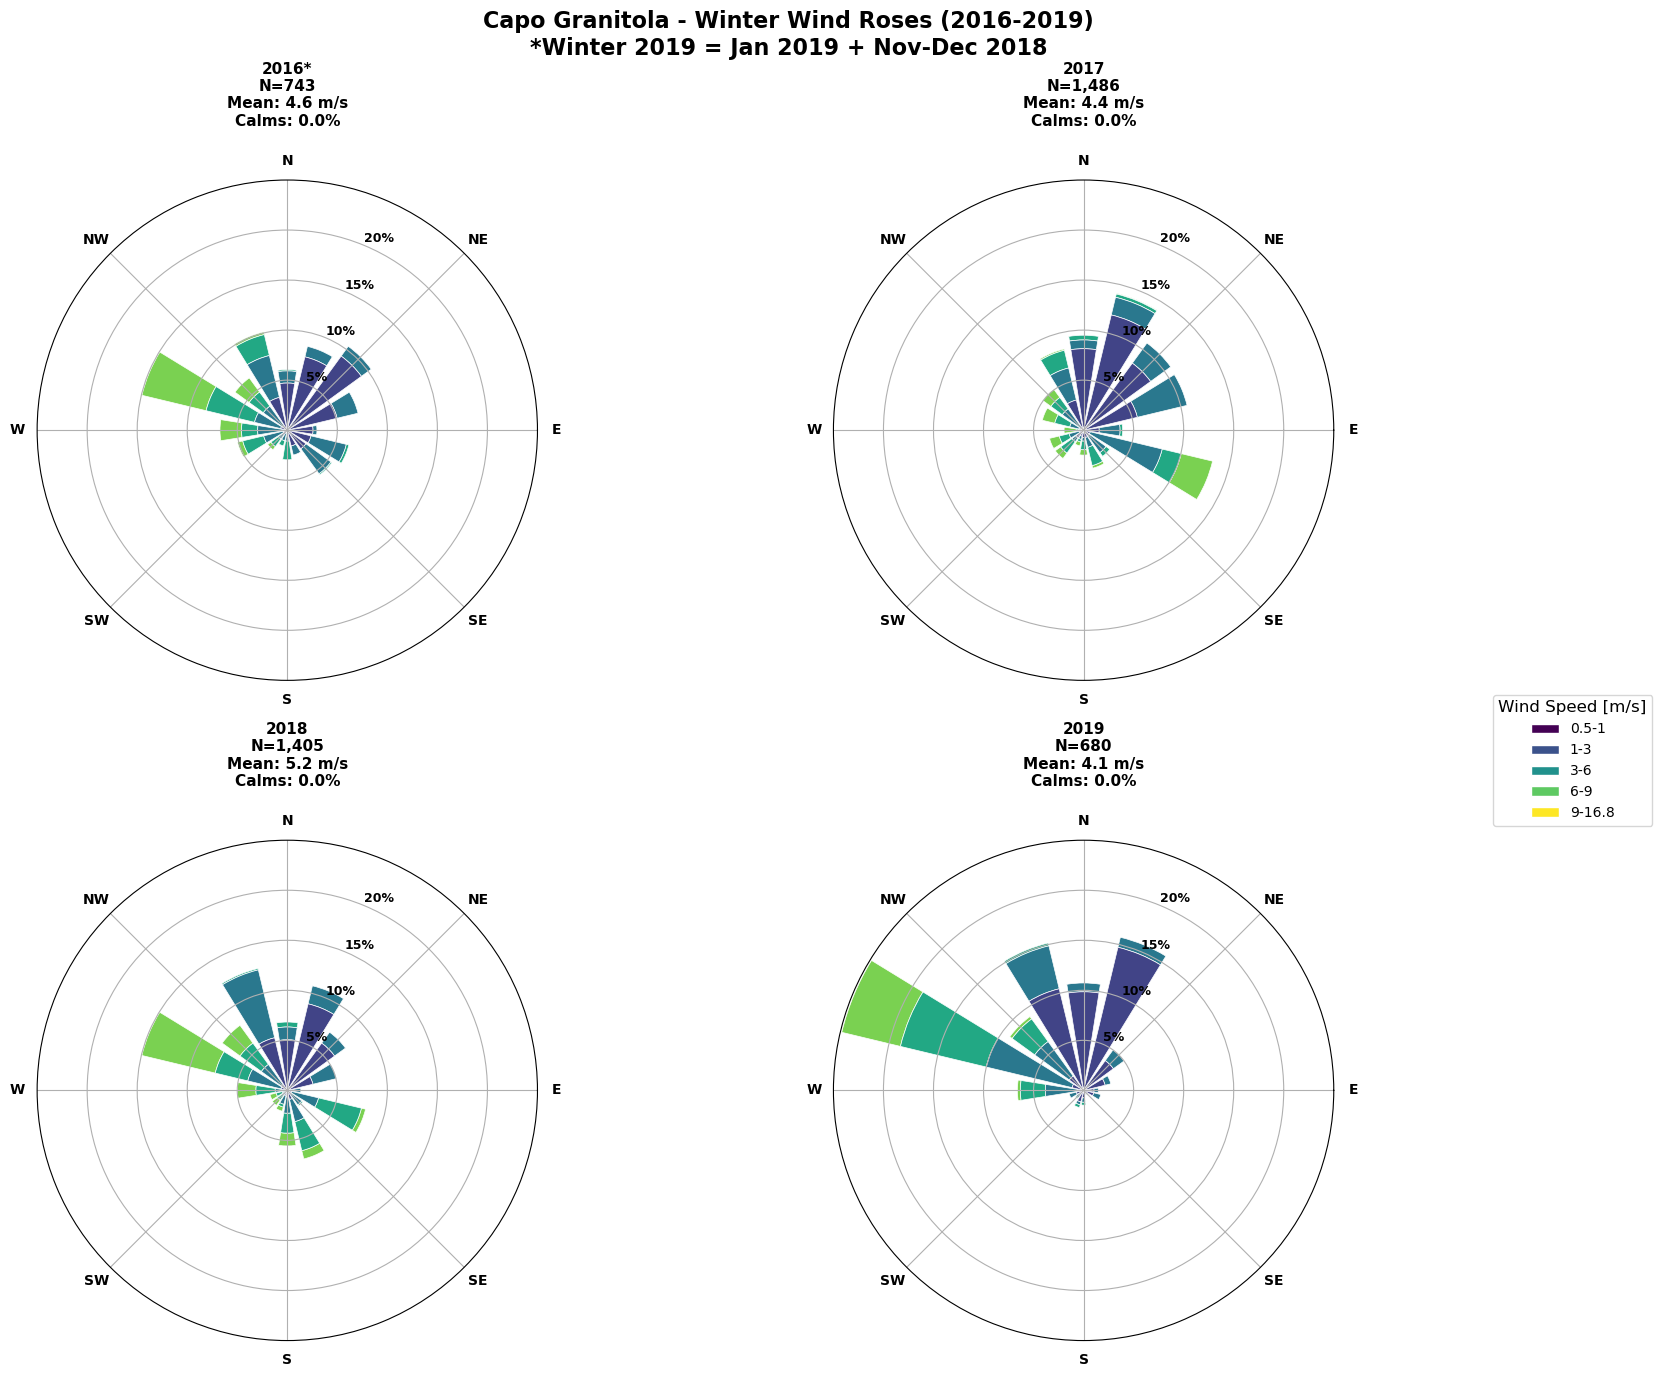


=== Creating wind rose figure for Spring ===
✓ Figure saved as 'wind_rose_CG_spring_2016_2019.png'



=== Creating wind rose figure for Summer ===
✓ Figure saved as 'wind_rose_CG_summer_2016_2019.png'


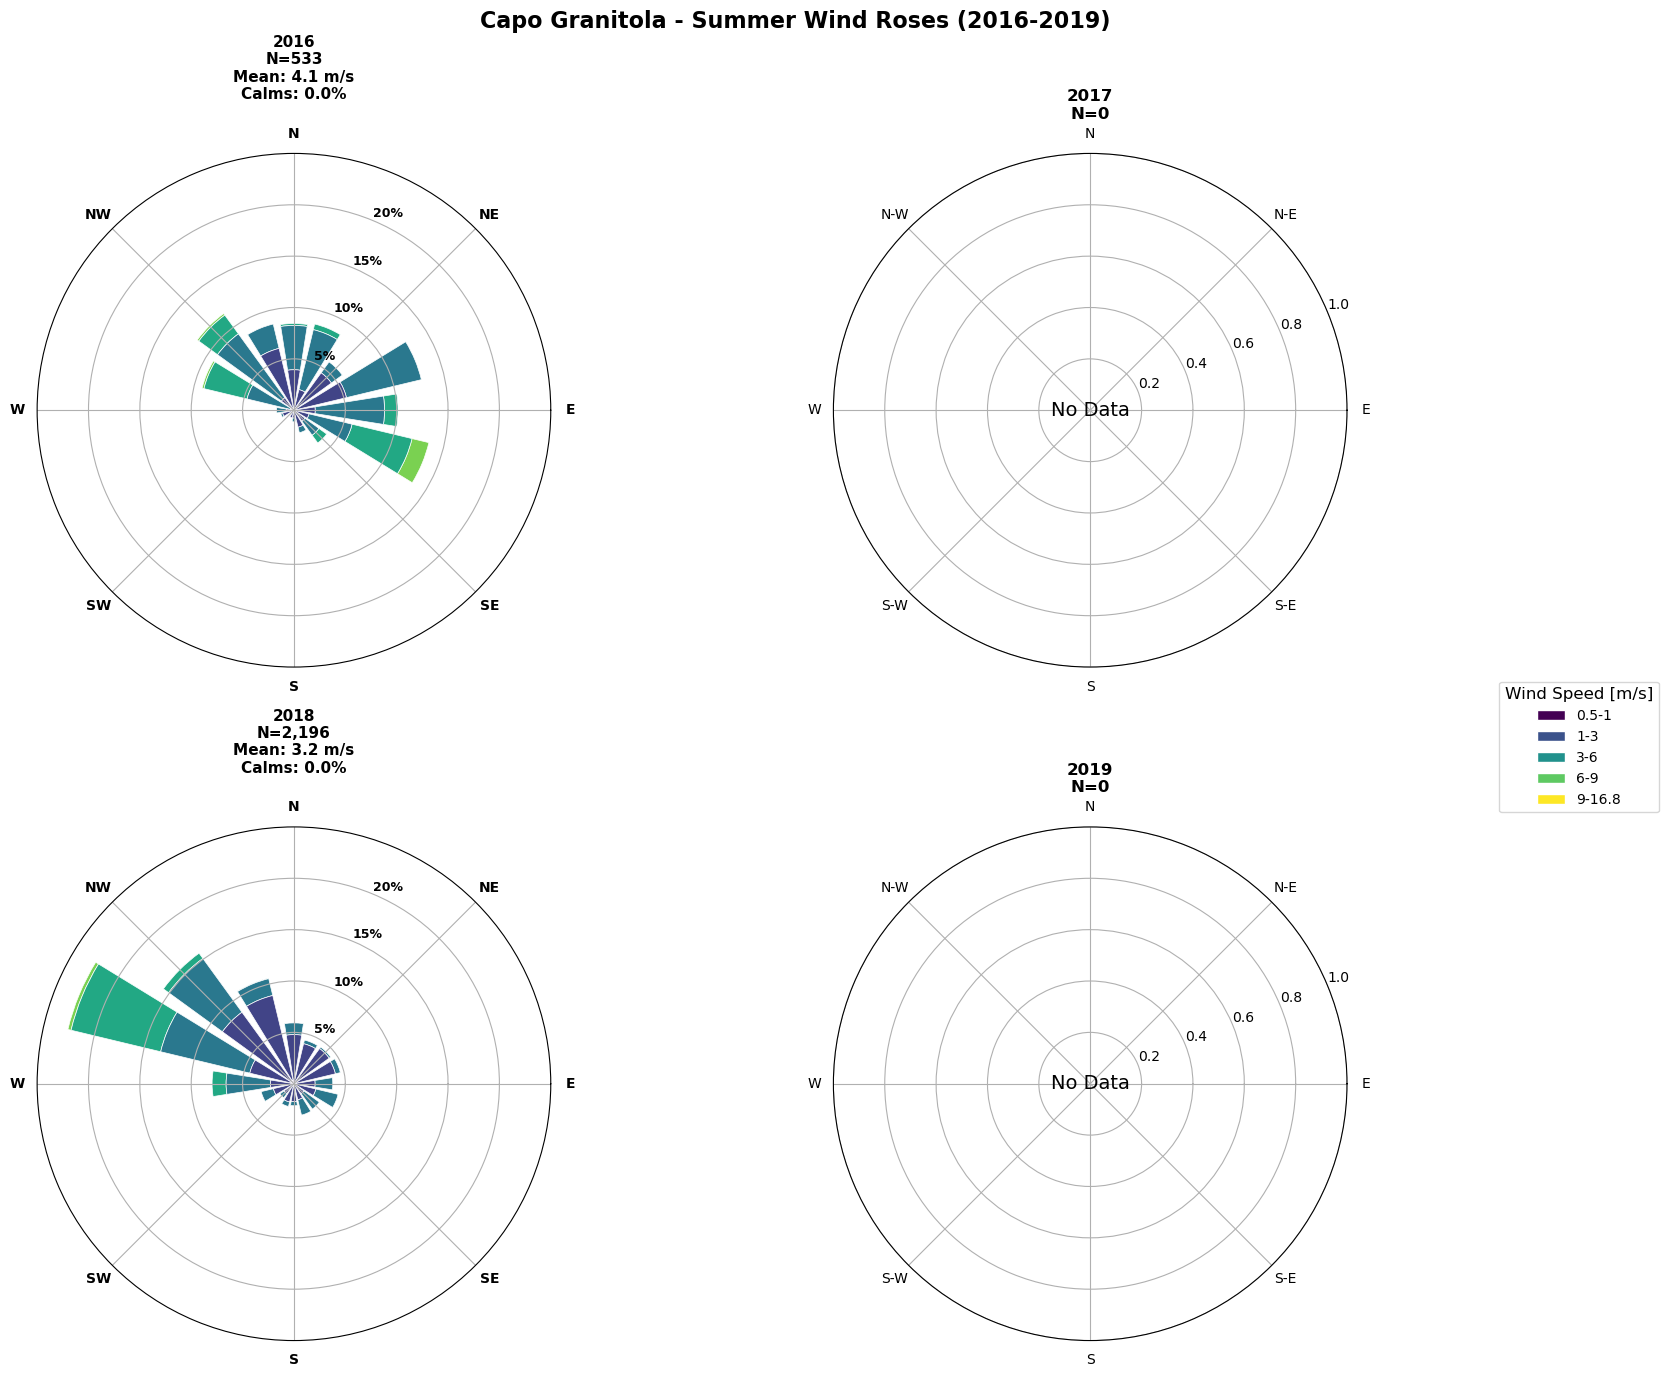


=== Creating wind rose figure for Autumn ===
✓ Figure saved as 'wind_rose_CG_autumn_2016_2019.png'


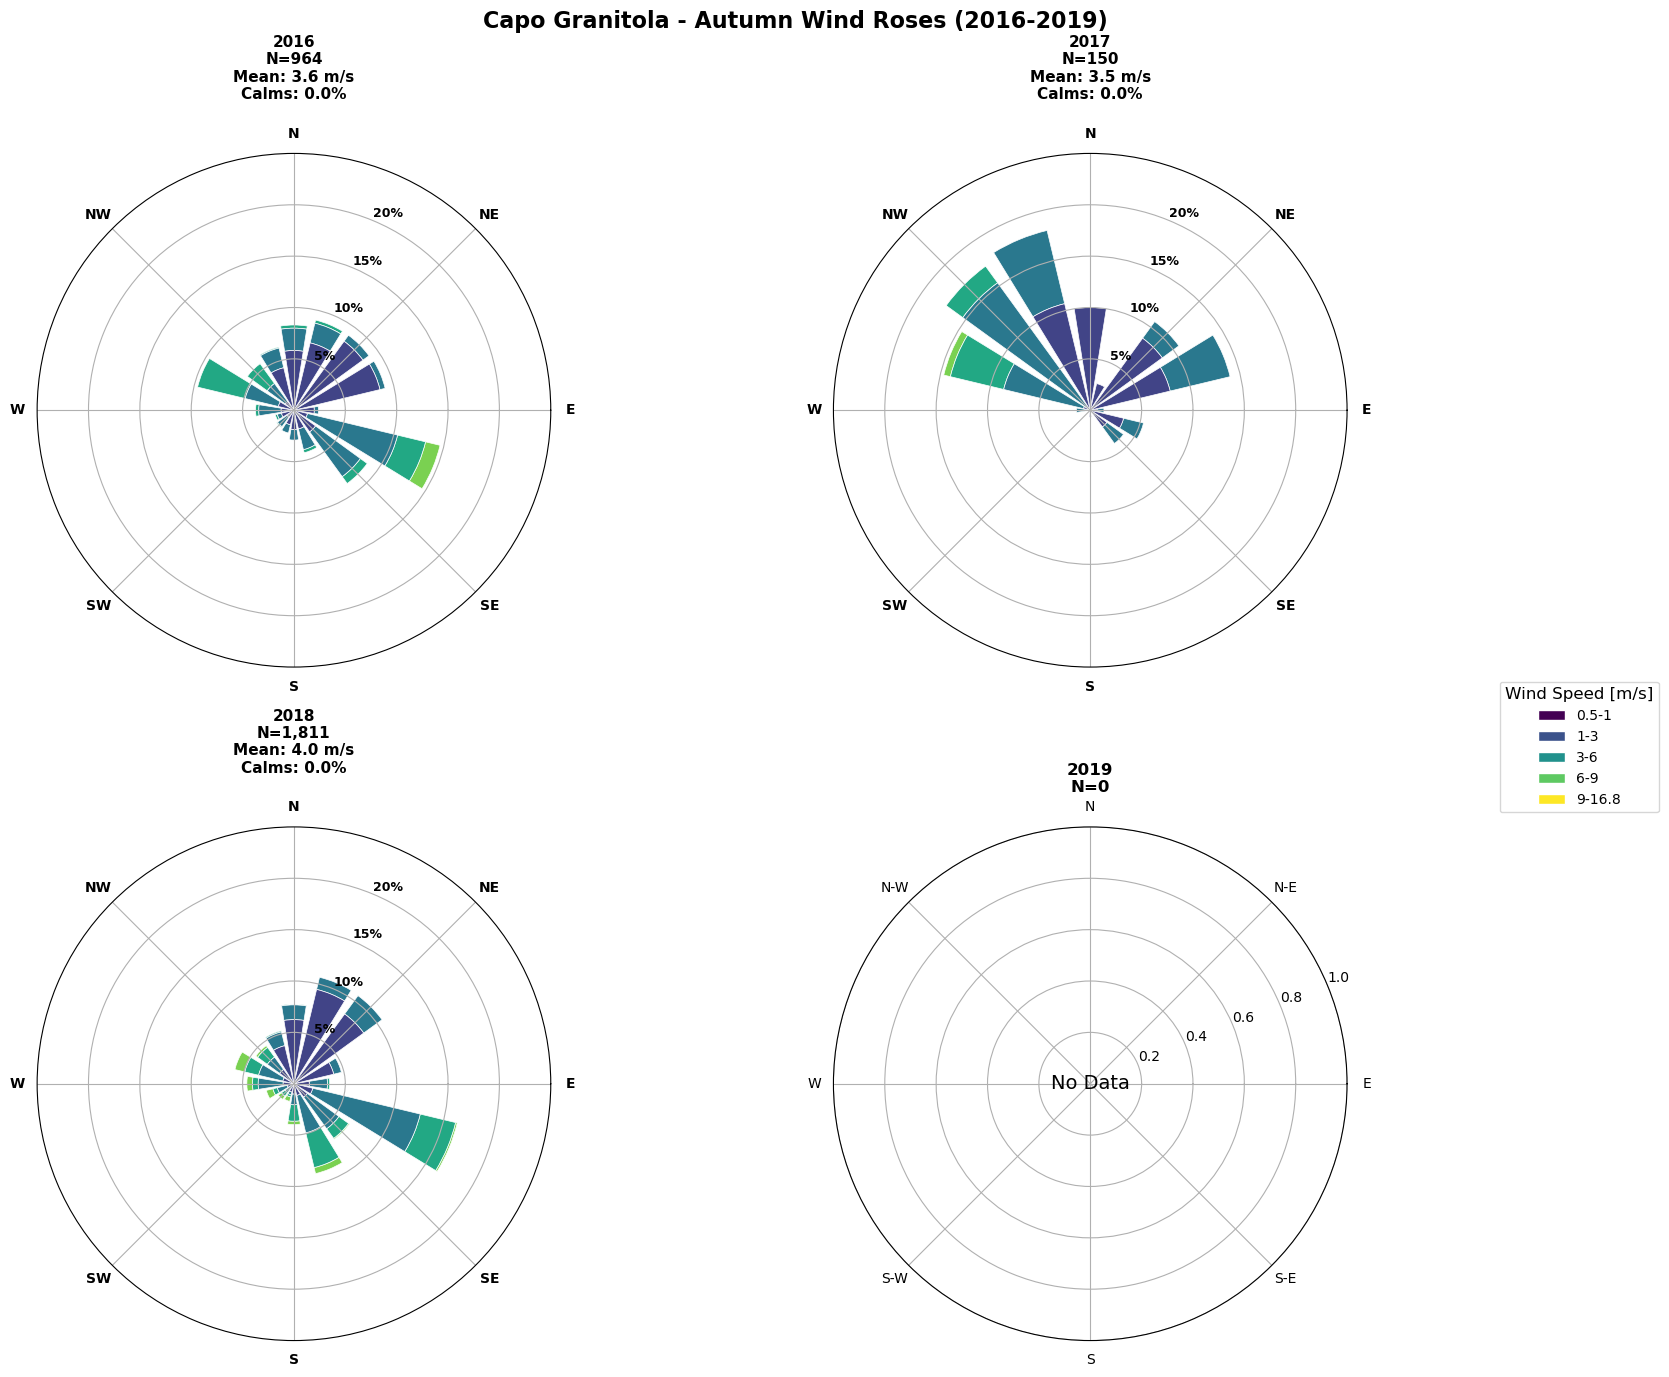


=== Creating summary figure with all seasons and years ===
✓ Summary figure saved as 'wind_rose_CG_all_seasons_years_summary.png'


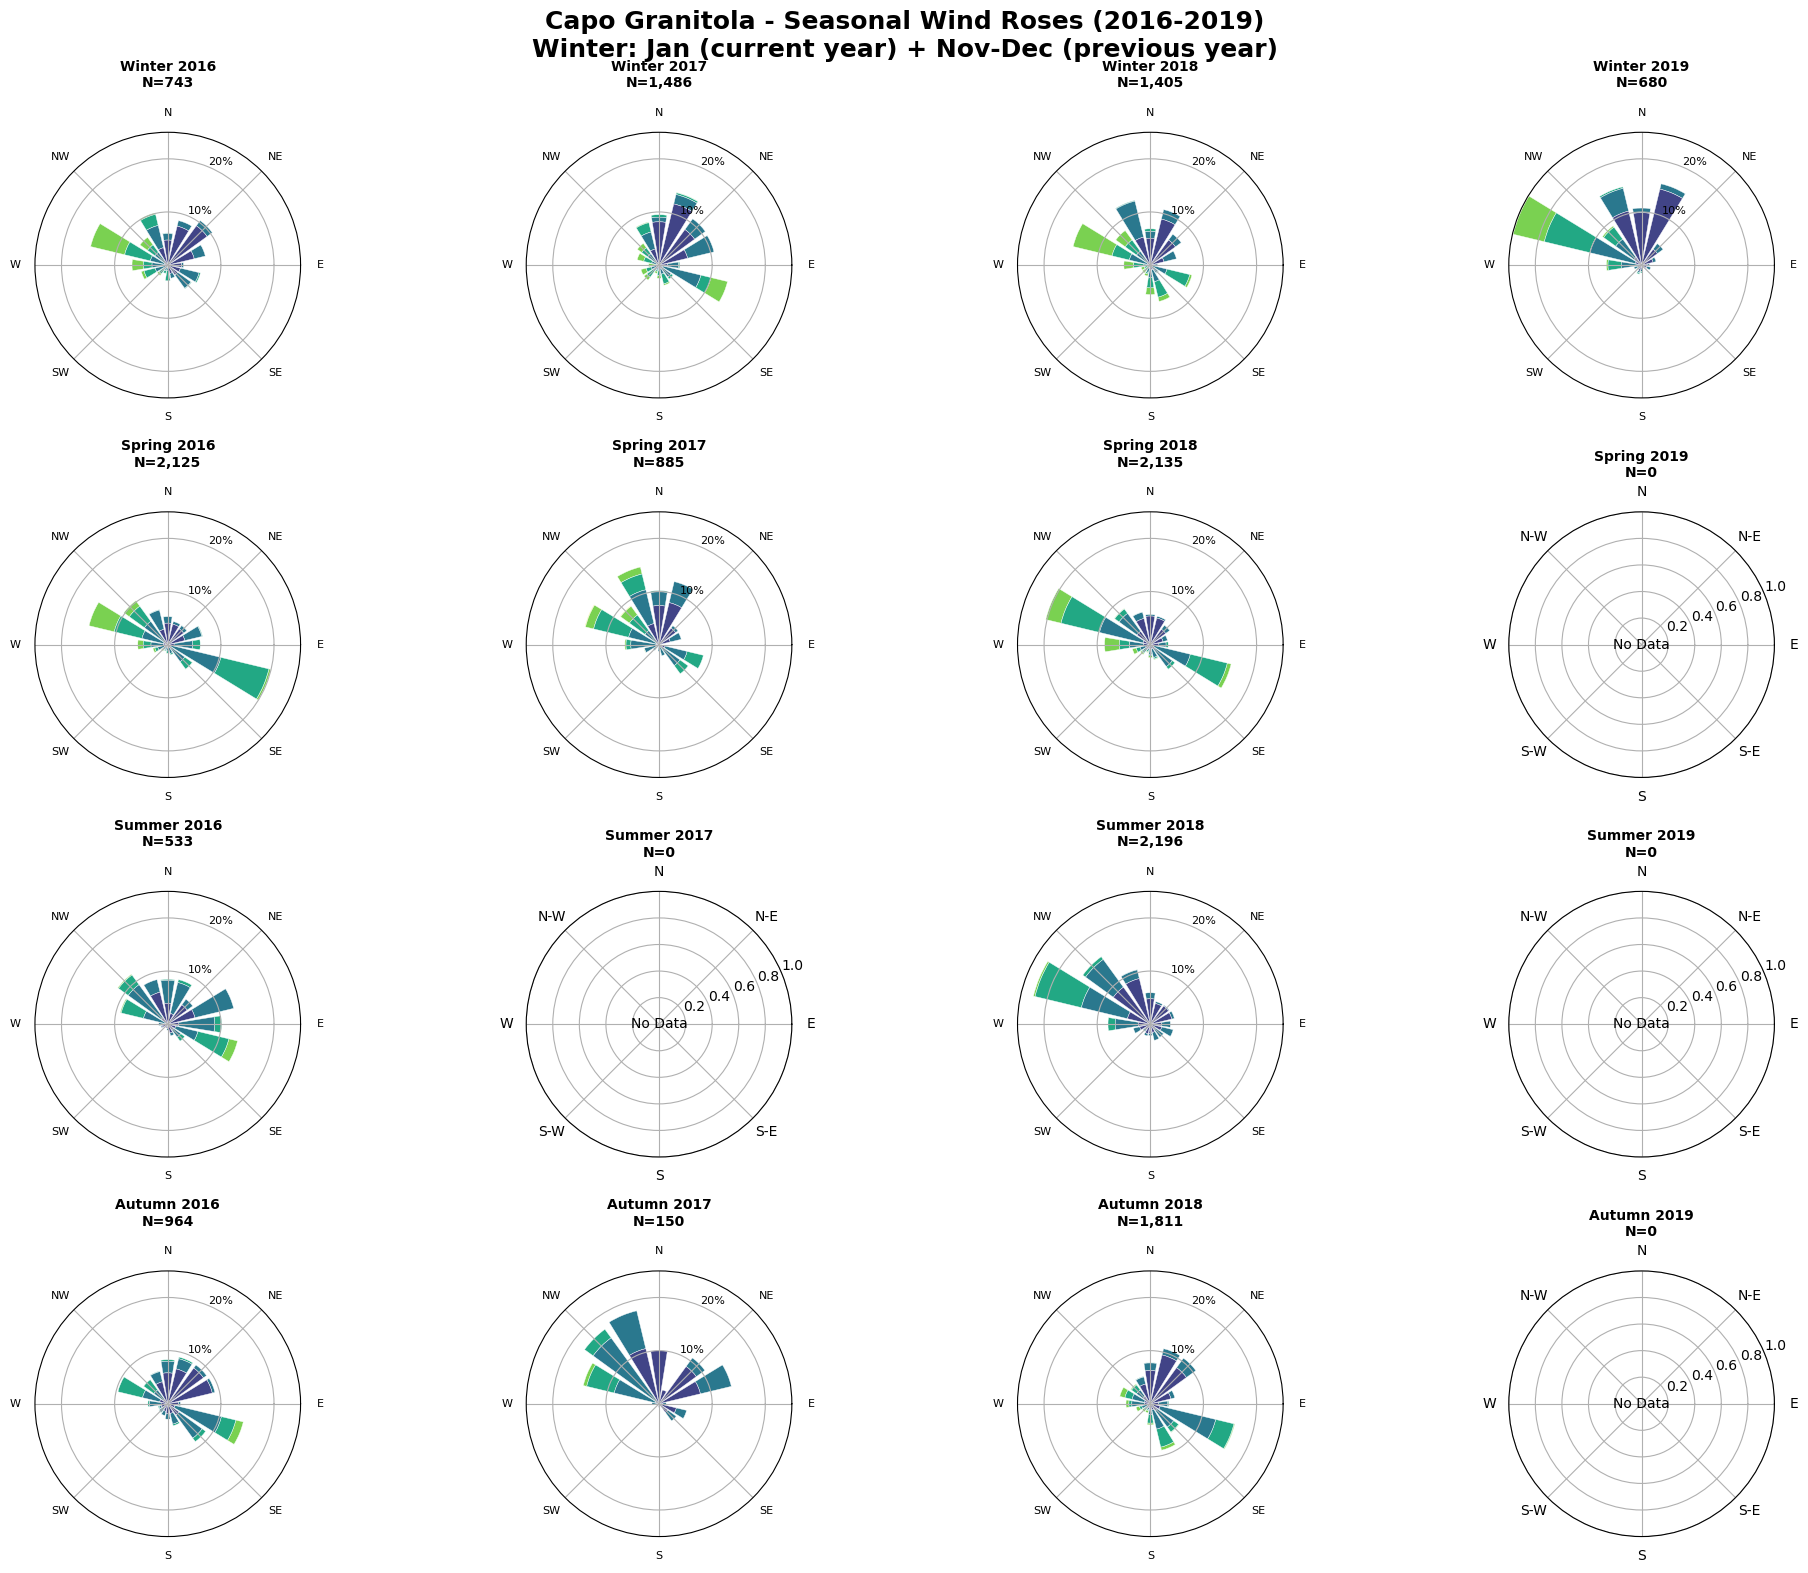


=== DATA SUMMARY BY SEASON AND YEAR ===

SEASONAL WIND DATA SUMMARY (2016-2019)
 Season-Year    N Mean Speed (m/s) Max Speed (m/s) Calms (%)
 Winter 2016  743             4.64           14.30       0.0
Winter 2017* 1486             4.38           15.40       0.0
Winter 2018* 1405             5.19           15.90       0.0
Winter 2019*  680             4.10           14.00       0.0
 Spring 2016 2125             5.09           15.50       0.0
 Spring 2017  885             4.59           16.80       0.0
 Spring 2018 2135             4.65           14.50       0.0
 Summer 2016  533             4.14           10.30       0.0
 Summer 2018 2196             3.24            9.50       0.0
 Autumn 2016  964             3.63           10.10       0.0
 Autumn 2017  150             3.53            9.30       0.0
 Autumn 2018 1811             3.98           15.60       0.0

*Winter 2017 = Jan 2017 + Nov-Dec 2016
Winter 2018 = Jan 2018 + Nov-Dec 2017
Winter 2019 = Jan 2019 + Nov-Dec 2018

=== UPDAT

In [36]:


# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")
print(f"\nIndex values (first 5):")
print(meteo_CG_16_19_filt.index[:5])

print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# Create a copy of the dataframe to avoid SettingWithCopyWarning
df = meteo_CG_16_19_filt.copy()

# Check if index is already datetime
print(f"\n=== CHECKING INDEX DATETIME STATUS ===")
print(f"Index dtype: {df.index.dtype}")

# Check if index needs to be converted to datetime
if not pd.api.types.is_datetime64_any_dtype(df.index):
    print("\nIndex is not datetime, converting...")
    try:
        df.index = pd.to_datetime(df.index)
        print("✓ Successfully converted index to datetime")
    except Exception as e:
        print(f"✗ Could not convert index to datetime: {e}")
        exit()
else:
    print("✓ Index is already datetime")

# Now you can use .month and .year on the index
# Use .loc to avoid SettingWithCopyWarning
df.loc[:, 'month'] = df.index.month
df.loc[:, 'year'] = df.index.year

print("✓ Added month and year from datetime index")
print(df[['wind_speed', 'wind_direction', 'month', 'year']].head())

# Add season based on month with your winter definition
print("\n=== ADDING SEASON (with your winter definition) ===")

def get_season(row):
    """
    Winter i-year = January i-year + November and December (i-1)-year
    So:
    - Jan: part of Winter of current year
    - Nov, Dec: part of Winter of NEXT year
    """
    month = row['month']
    year = row['year']
    
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    elif month == 1:
        # January is part of Winter of the current year
        return 'Winter'
    elif month in [12]:
        # November and December are part of Winter of NEXT year
        return 'Winter'
    else:
        return 'Unknown'

def get_season_year(row):
    """
    Determine which year's season this record belongs to.
    For non-winter months: use current year
    For Jan, Feb: use current year (Winter 2017 includes Jan, Febr 2017)
    For  Dec: use previous year (Winter 2017 includes Dec 2016)
    """
    month = row['month']
    year = row['year']
    
    if month in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Spring, Summer, Autumn: use current year
        return year
    elif month in [1,2]:
        # January, Febraury: Winter of next year
        return year
    elif month ==12:
        #  December: Winter of current year
        return year + 1
    else:
        return year

# Apply season functions using .loc
df.loc[:, 'season'] = df.apply(get_season, axis=1)
df.loc[:, 'season_year'] = df.apply(get_season_year, axis=1)
df.loc[:, 'season_period'] = df['season'] + ' ' + df['season_year'].astype(str)

print("✓ Added season, season_year, and season_period columns")

# Define wind speed bins
speed_bins = [0.5, 1, 3, 6, 9, df['wind_speed'].max()]
bin_labels = [
    '0.5-1',
    '1-3',
    '3-6',
    '6-9',
    f'9-{df["wind_speed"].max():.1f}'
]

# Define seasons and years
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
years = [2016, 2017, 2018, 2019]

# Create a separate figure for each season
for season in seasons:
    print(f"\n=== Creating wind rose figure for {season} ===")
    
    # Create figure with 2x2 grid for the 4 years
    fig = plt.figure(figsize=(18, 14))
    
    # Create GridSpec for better layout control
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.2], height_ratios=[1, 1])
    
    # Create subplots for each year
    axes = []
    for i, year in enumerate(years):
        row = i // 2
        col = i % 2
        
        # Create windrose subplot
        ax = fig.add_subplot(gs[row, col], projection='windrose')
        axes.append(ax)
        
        # Filter data for this season and year
        if season == 'Winter':
            # For Winter, we need to filter differently based on season_year
            # Winter 2017 includes Jan 2017 + Nov-Dec 2016
            season_mask = (df['season'] == 'Winter') & (df['season_year'] == year)
        else:
            # For other seasons, use year directly
            season_mask = (df['season'] == season) & (df['year'] == year)
        
        season_data = df[season_mask]
        
        # Extract wind data
        ws = season_data['wind_speed'].values
        wd = season_data['wind_direction'].values
        
        # Skip if no data
        if len(ws) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{year}\nN=0', fontsize=12, fontweight='bold')
            continue
        
        # Plot wind rose
        bars = ax.bar(wd, ws, normed=True, opening=0.8, 
                      edgecolor='white', linewidth=0.5, 
                      bins=speed_bins, cmap=plt.cm.viridis)
        
        # Customize frequency circles
        ax.set_yticks([5, 10, 15, 20])
        ax.set_yticklabels(['5%', '10%', '15%', '20%'], 
                          fontsize=9, fontweight='bold')
        ax.set_ylim(0, 25)
        
        # Customize directional labels
        ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], 
                          fontsize=10, fontweight='bold')
        
        # Calculate statistics
        total_points = len(ws)
        mean_speed = np.mean(ws)
        max_speed = np.max(ws)
        calms = np.sum(ws < 0.5)
        calm_percentage = (calms / total_points) * 100 if total_points > 0 else 0
        
        # Set title with statistics
        if season == 'Winter':
            # Special title for winter showing composition
            if year == 2016:
                title = f'{year}*\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
            else:
                title = f'{year}\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
        else:
            title = f'{year}\nN={total_points:,}\nMean: {mean_speed:.1f} m/s\nCalms: {calm_percentage:.1f}%'
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=20)
    
    # Add legend in the right column
    ax_legend = fig.add_subplot(gs[:, 2])
    ax_legend.axis('off')
    
    # Create custom legend
    legend_elements = []
    colors = plt.cm.viridis(np.linspace(0, 1, len(bin_labels)))
    
    for i, (label, color) in enumerate(zip(bin_labels, colors)):
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, 
                                            edgecolor='white', label=label))
    
    ax_legend.legend(handles=legend_elements, title='Wind Speed [m/s]',
                     loc='center', fontsize=10, title_fontsize=12)
    
    # Add main title
    if season == 'Winter':
        fig.suptitle(f'Capo Granitola - {season} Wind Roses (2016-2019)\n'
                    f'*Winter {year} = Jan {year} + Nov-Dec {year-1}', 
                    fontsize=16, fontweight='bold', y=0.98)
    else:
        fig.suptitle(f'Capo Granitola - {season} Wind Roses (2016-2019)', 
                    fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save figure
    output_filename = f'wind_rose_CG_{season.lower()}_2016_2019.png'
    fig.savefig(output_filename, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✓ Figure saved as '{output_filename}'")
    
    plt.show()

# Create a summary figure with all seasons in one plot (4x4 grid)
print("\n=== Creating summary figure with all seasons and years ===")

fig_all = plt.figure(figsize=(20, 16))
fig_all.suptitle('Capo Granitola - Seasonal Wind Roses (2016-2019)\n'
                 'Winter: Jan (current year) + Nov-Dec (previous year)', 
                 fontsize=18, fontweight='bold', y=0.98)

for i, season in enumerate(seasons):
    for j, year in enumerate(years):
        ax_idx = i * 4 + j + 1
        ax = fig_all.add_subplot(4, 4, ax_idx, projection='windrose')
        
        # Filter data
        if season == 'Winter':
            season_mask = (df['season'] == 'Winter') & (df['season_year'] == year)
        else:
            season_mask = (df['season'] == season) & (df['year'] == year)
        
        season_data = df[season_mask]
        
        # Extract wind data
        ws = season_data['wind_speed'].values
        wd = season_data['wind_direction'].values
        
        if len(ws) > 0:
            # Plot wind rose
            bars = ax.bar(wd, ws, normed=True, opening=0.8, 
                          edgecolor='white', linewidth=0.3, 
                          bins=speed_bins, cmap=plt.cm.viridis)
            
            # Calculate statistics
            total_points = len(ws)
            mean_speed = np.mean(ws)
            calms = np.sum(ws < 0.5)
            calm_percentage = (calms / total_points) * 100 if total_points > 0 else 0
            
            # Simplified title
            if season == 'Winter' and year != 2016:
                title = f'{season} {year}\nN={total_points:,}'
            else:
                title = f'{season} {year}\nN={total_points:,}'
            
            ax.set_title(title, fontsize=10, fontweight='bold', pad=15)
            
            # Simplified labels
            ax.set_yticks([10, 20])
            ax.set_yticklabels(['10%', '20%'], fontsize=8)
            ax.set_ylim(0, 25)
            ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], 
                              fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{season} {year}\nN=0', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save summary figure
output_all = 'wind_rose_CG_all_seasons_years_summary.png'
fig_all.savefig(output_all, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
print(f"✓ Summary figure saved as '{output_all}'")

plt.show()

# Print data summary for each season-year combination
print("\n=== DATA SUMMARY BY SEASON AND YEAR ===")
summary_data = []

for season in seasons:
    for year in years:
        if season == 'Winter':
            mask = (df['season'] == 'Winter') & (df['season_year'] == year)
        else:
            mask = (df['season'] == season) & (df['year'] == year)
        
        data = df[mask]
        
        if len(data) > 0:
            ws = data['wind_speed'].values
            total_points = len(ws)
            mean_speed = np.mean(ws)
            max_speed = np.max(ws)
            calms = np.sum(ws < 0.5)
            calm_percentage = (calms / total_points) * 100 if total_points > 0 else 0
            
            if season == 'Winter' and year != 2016:
                season_label = f'Winter {year}*'
            else:
                season_label = f'{season} {year}'
            
            summary_data.append({
                'Season-Year': season_label,
                'N': total_points,
                'Mean Speed (m/s)': f'{mean_speed:.2f}',
                'Max Speed (m/s)': f'{max_speed:.2f}',
                'Calms (%)': f'{calm_percentage:.1f}'
            })

# Create and display summary table
summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SEASONAL WIND DATA SUMMARY (2016-2019)")
print("="*80)
print(summary_df.to_string(index=False))
print("\n*Winter 2017 = Jan 2017 + Nov-Dec 2016")
print("Winter 2018 = Jan 2018 + Nov-Dec 2017")
print("Winter 2019 = Jan 2019 + Nov-Dec 2018")
print("="*80)

# Also update the original dataframe if needed
print("\n=== UPDATING ORIGINAL DATAFRAME ===")
# Copy the new columns back to the original dataframe
for col in ['month', 'year', 'season', 'season_year', 'season_period']:
    if col in df.columns:
        meteo_CG_16_19_filt.loc[:, col] = df[col].values

print("✓ Updated original dataframe with new columns")

print("\n=== ANALYSIS COMPLETE ===")
print(f"Total figures created: {len(seasons)} seasonal figures + 1 summary figure")
print("Figures saved with 300 DPI resolution")

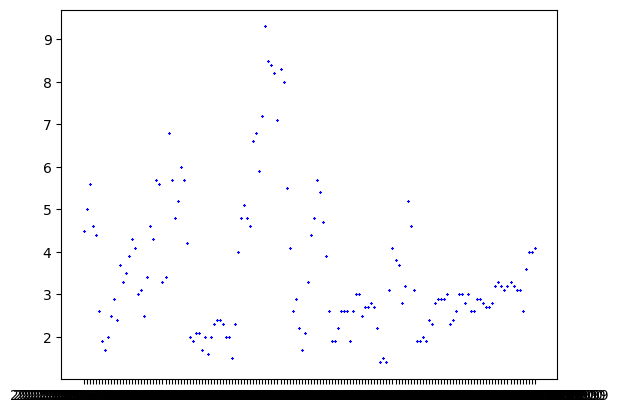

In [17]:
# Define date range
start_date1 = '2017-09-01'
end_date1 = '2017-11-31'

# Create subset based on date range using loc (inclusive of both dates)
meteo_CG_check = filt_df_CG.loc[start_date1:end_date1]

# Apply condition: keep rows where ws_2m > 0.5
meteo_CG_check_filt =meteo_CG_check[meteo_CG_check['wind_speed'] > 0.5]

plt.scatter(meteo_CG_check_filt.index, meteo_CG_check_filt['wind_speed'], marker='x', s=0.6, color='blue', label='Temperature')